# Ресерч

В рамках данного ресерча будет:

1) Проанализировано влияние новостей

    1.1) Построены графики

    1.2) Предобработаны данные

    1.3) Размечены данные (потом это пойдет в Marker.py). На разметке будет обучена модель ранжирования сентимента новостей. Данные будут размечены при помощи LLM (CoT + Few-shot) и провалидированы вручную

    1.4) Удалены выбросы

    1.5) Выполнена кластеризация

    1.6) Завершена предобработка

2) Обучена модель (Семейство моделей на разных эмбеддингах / архитектурах)

3) Анализ  Feature importance

4) Подготовка дообучения модели (Потом пойдет в класс Model)

## Установка необходимых библиотек

Для первичной обработки данных

In [57]:
! pip install pandas numpy seaborn matplotlib pyarrow langchain-ollama langchain_community scikit-learn spacy wordcloud xgboost  sentence-transformers imblearn 
! pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.4 MB/s eta 0:00:00


## Импортирование библиотек

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
from langchain_community.llms import Ollama
from langchain_core.prompts import ChatPromptTemplate
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import re
from wordcloud import WordCloud
import spacy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.sparse import hstack
import torch
from sentence_transformers import SentenceTransformer
import pandas as pd


import lightgbm as lgb

## Первичный анализ входных данных

Откроем файлы

In [4]:
moex_data = pd.read_parquet('../data/moex.parquet')
news_data = pd.read_parquet('../data/news.parquet')
webnews_data = pd.read_parquet('../data/webnews.parquet')
webnews_data['sphere'] = webnews_data['type']
webnews_data.drop(columns=['type'], inplace=True)

Посмотрим на их структуру

In [5]:
moex_data.head()

,company,open,close,begin,end
0,SBER,141.60,141.60,2023-01-03 09:00:00,2023-01-03 09:59:59
1,SBER,141.60,142.66,2023-01-03 10:00:00,2023-01-03 10:59:59
2,SBER,142.66,142.42,2023-01-03 11:00:00,2023-01-03 11:59:59
3,SBER,142.43,141.91,2023-01-03 12:00:00,2023-01-03 12:59:59
4,SBER,141.91,141.67,2023-01-03 13:00:00,2023-01-03 13:59:59


In [6]:
news_data.head()

,title,datetime,article_text,sphere,source
0,"**Вы знали, что на вашем СНИЛСе хранятся деньги?",2025-02-21T10:11,"**Вы знали, что на вашем СНИЛСе хранятся деньг...",Энергетика,Копейка рубль бережёт
1,🤑Ещё 13 российских банков отключат от SWIFT в ...,2025-02-21T08:21,🤑Ещё 13 российских банков отключат от SWIFT в ...,Финансы,Копейка рубль бережёт
2,🤑Страны G7 намерены отказаться от идеи ужесточ...,2025-02-21T04:28,🤑Страны G7 намерены отказаться от идеи ужесточ...,Энергетика,Копейка рубль бережёт
3,🤑«АвтоВАЗ» опроверг какие-либо контакты с комп...,2025-02-20T16:03,🤑«АвтоВАЗ» опроверг какие-либо контакты с комп...,Энергетика,Копейка рубль бережёт
4,"🤑Официальный курс доллара — ₽88,5.",2025-02-20T15:11,"🤑Официальный курс доллара — ₽88,5. Центробанк ...",Финансы,Копейка рубль бережёт


In [7]:
webnews_data.head()

,title,datetime,article_text,source,sphere
0,ЦБ РФ на заседании в марте может рассмотреть и...,2025-03-01T13:39,Москва. 1 марта. INTERFAX.RU - ЦБ РФ на засед...,Интерфакс,Финансы
1,ЦБ сможет учитывать движения на рынках на фоне...,2025-03-01T12:33,Москва. 1 марта. INTERFAX.RU - Наблюдающиеся ...,Интерфакс,Энергетика
2,Банк России по-прежнему жестко настроен на воз...,2025-03-01T11:57,Москва. 1 марта. INTERFAX.RU - Банк России по...,Интерфакс,Энергетика
3,ЦБ РФ сможет полностью оценить тенденции в кре...,2025-03-01T11:49,Москва. 1 марта. INTERFAX.RU - Банк России см...,Интерфакс,Финансы
4,Пошлина на экспорт подсолнечного масла из РФ в...,2025-03-01T00:14,Москва. 1 марта. INTERFAX.RU - Пошлина на экс...,Интерфакс,Энергетика


Посмотрим количество записей для каждой из компаний

In [8]:
moex_data.groupby('company').count()

,open,close,begin,end
company,,,,
GAZP,8314,8314,8314,8314
LKOH,8314,8314,8314,8314
ROSN,8314,8314,8314,8314
SBER,8314,8314,8314,8314
T,8029,8029,8029,8029
VTBR,8254,8254,8254,8254


Выполним аналогичную операцию со сферами

In [9]:
news_data.groupby('sphere').count()

,title,datetime,article_text,source
sphere,,,,
Финансы,3268,3268,3268,3268
Финансы/Энергетика,338,338,338,338
Энергетика,3745,3745,3745,3745


In [10]:
webnews_data.groupby('sphere').count()

,title,datetime,article_text,source
sphere,,,,
Финансы,2743,2743,2743,2743
Финансы/Энергетика,379,379,379,379
Энергетика,2984,2984,2984,2984


Посмотрим начало и конец периодов для записей данных

In [11]:
moex_data['begin'] = pd.to_datetime(moex_data['begin'])
moex_data['end'] = pd.to_datetime(moex_data['end'])

print(min(moex_data['begin']))
print(max(moex_data['end']))


2023-01-03 09:00:00
2025-02-28 20:34:02


In [12]:
news_data['datetime'] = pd.to_datetime(news_data['datetime'])
print(min(news_data['datetime']))
print(max(news_data['datetime']))

2022-09-01 07:10:00
2025-02-21 10:59:00


In [13]:
webnews_data['datetime'] = pd.to_datetime(webnews_data['datetime'])
print(min(webnews_data['datetime']))
print(max(webnews_data['datetime']))

2024-10-31 13:31:00
2025-03-01 13:39:00


Заметим, что у нас маленький период данных по webnews, так что их мы никак будем ограничивать по остальным параметрам

Оставим только данные в один и тот же период

In [14]:
min_news_datetime = min(news_data['datetime'])
max_news_datetime = max(news_data['datetime'])
min_moex_begin = min(moex_data['begin'])
max_moex_end = max(moex_data['end'])

lower_bound = max(min_news_datetime, min_moex_begin)
upper_bound = min(max_news_datetime, max_moex_end)

news_data = news_data[(news_data['datetime'] >= lower_bound) & (news_data['datetime'] <= upper_bound)]

moex_data = moex_data[(moex_data['begin'] >= lower_bound) & (moex_data['end'] <= upper_bound)]
webnews_data = webnews_data[(webnews_data['datetime'] >= lower_bound) & (webnews_data['datetime'] <= upper_bound)]

In [15]:
print('moex data')
print(min(moex_data['begin']))
print(max(moex_data['end']))

print('news_data')
print(min(news_data['datetime']))
print(max(news_data['datetime']))

print('webnews_data')
print(min(webnews_data['datetime']))
print(max(webnews_data['datetime']))

moex data
2023-01-03 09:00:00
2025-02-21 09:59:59
news_data
2023-01-03 09:16:00
2025-02-21 10:59:00
webnews_data
2024-10-31 13:31:00
2025-02-21 10:58:00


Визуализируем цены акций

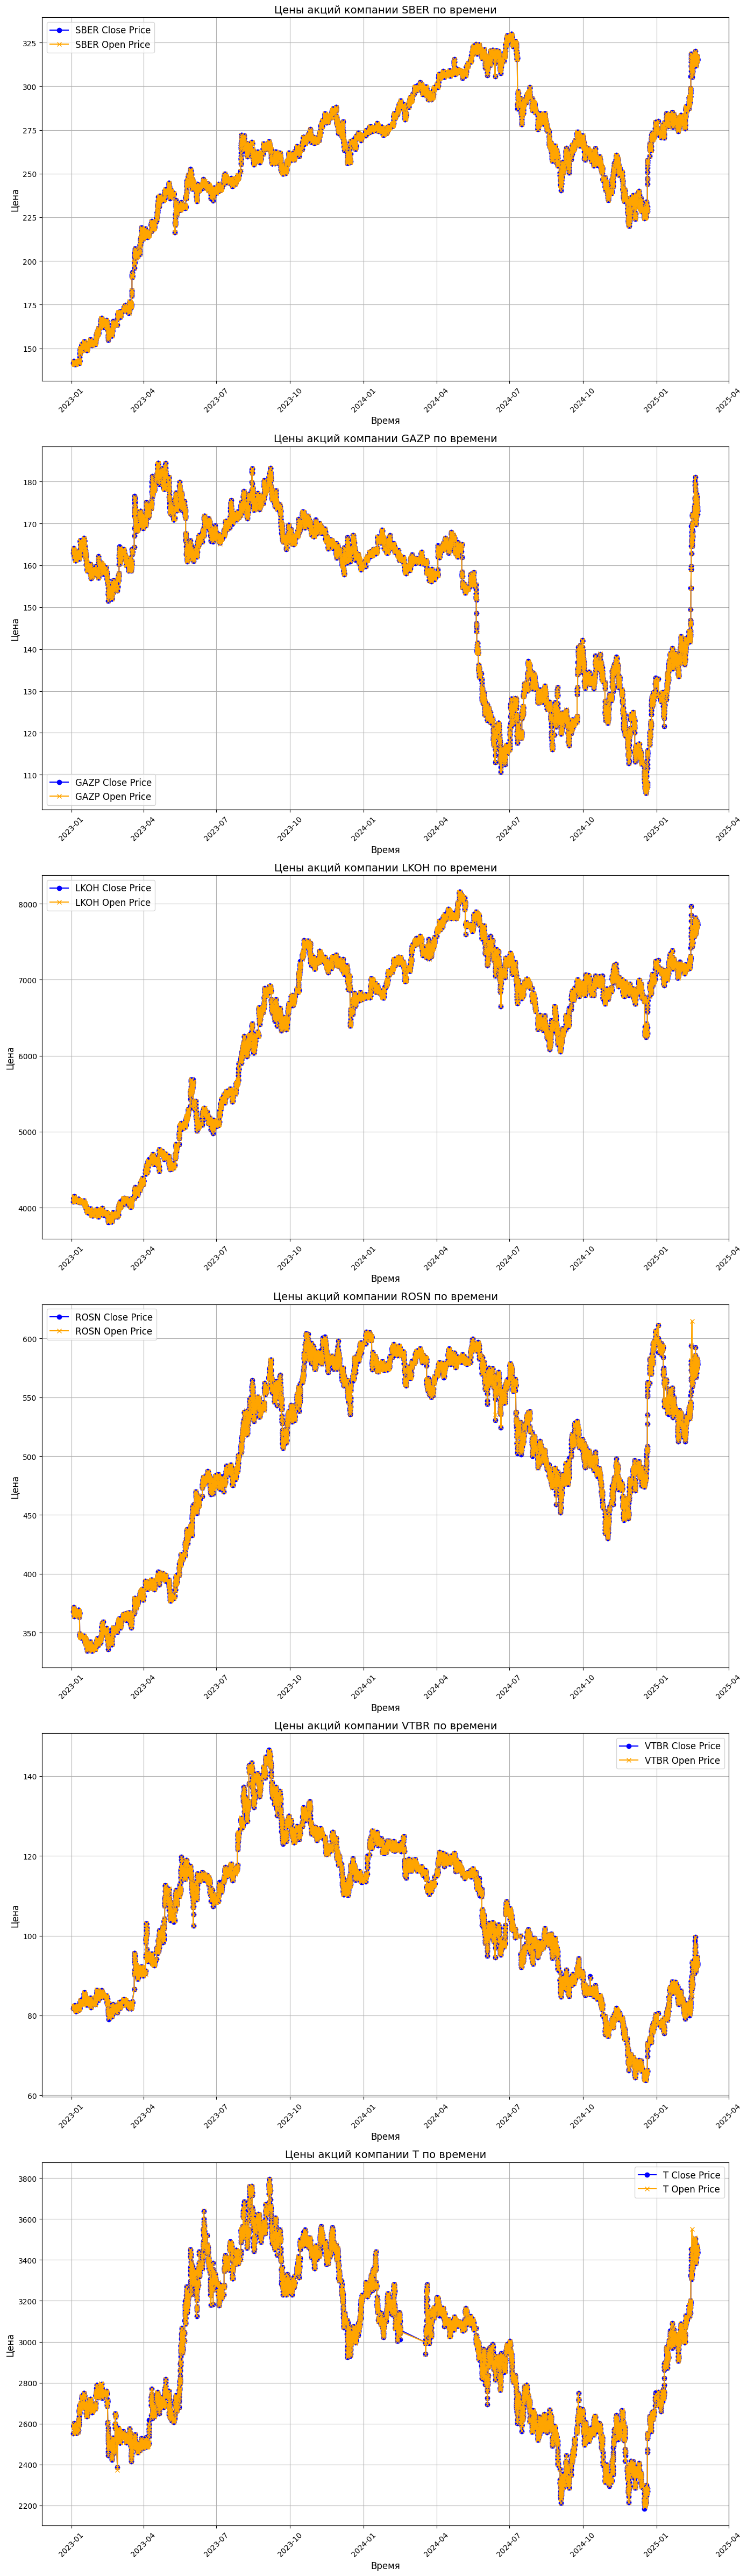

In [16]:
companies = moex_data['company'].unique()

plt.figure(figsize=(14, 8 * len(companies))) 
for i, company in enumerate(companies, 1):
    plt.subplot(len(companies), 1, i)  
    company_data = moex_data[moex_data['company'] == company]
    plt.plot(company_data['begin'], company_data['close'], label=f'{company} Close Price', color='blue', marker='o')
    plt.plot(company_data['begin'], company_data['open'], label=f'{company} Open Price', color='orange', marker='x')
    plt.title(f'Цены акций компании {company} по времени', fontsize=14)
    plt.xlabel('Время', fontsize=12)
    plt.ylabel('Цена', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()

Визуализируем количество новостей за этот период

Дата с максимальным количеством новостей для сферы 'Энергетика': 2024-03-06
Дата с максимальным количеством новостей для сферы 'Финансы': 2024-11-21
Дата с максимальным количеством новостей для сферы 'Финансы/Энергетика': 2024-09-04


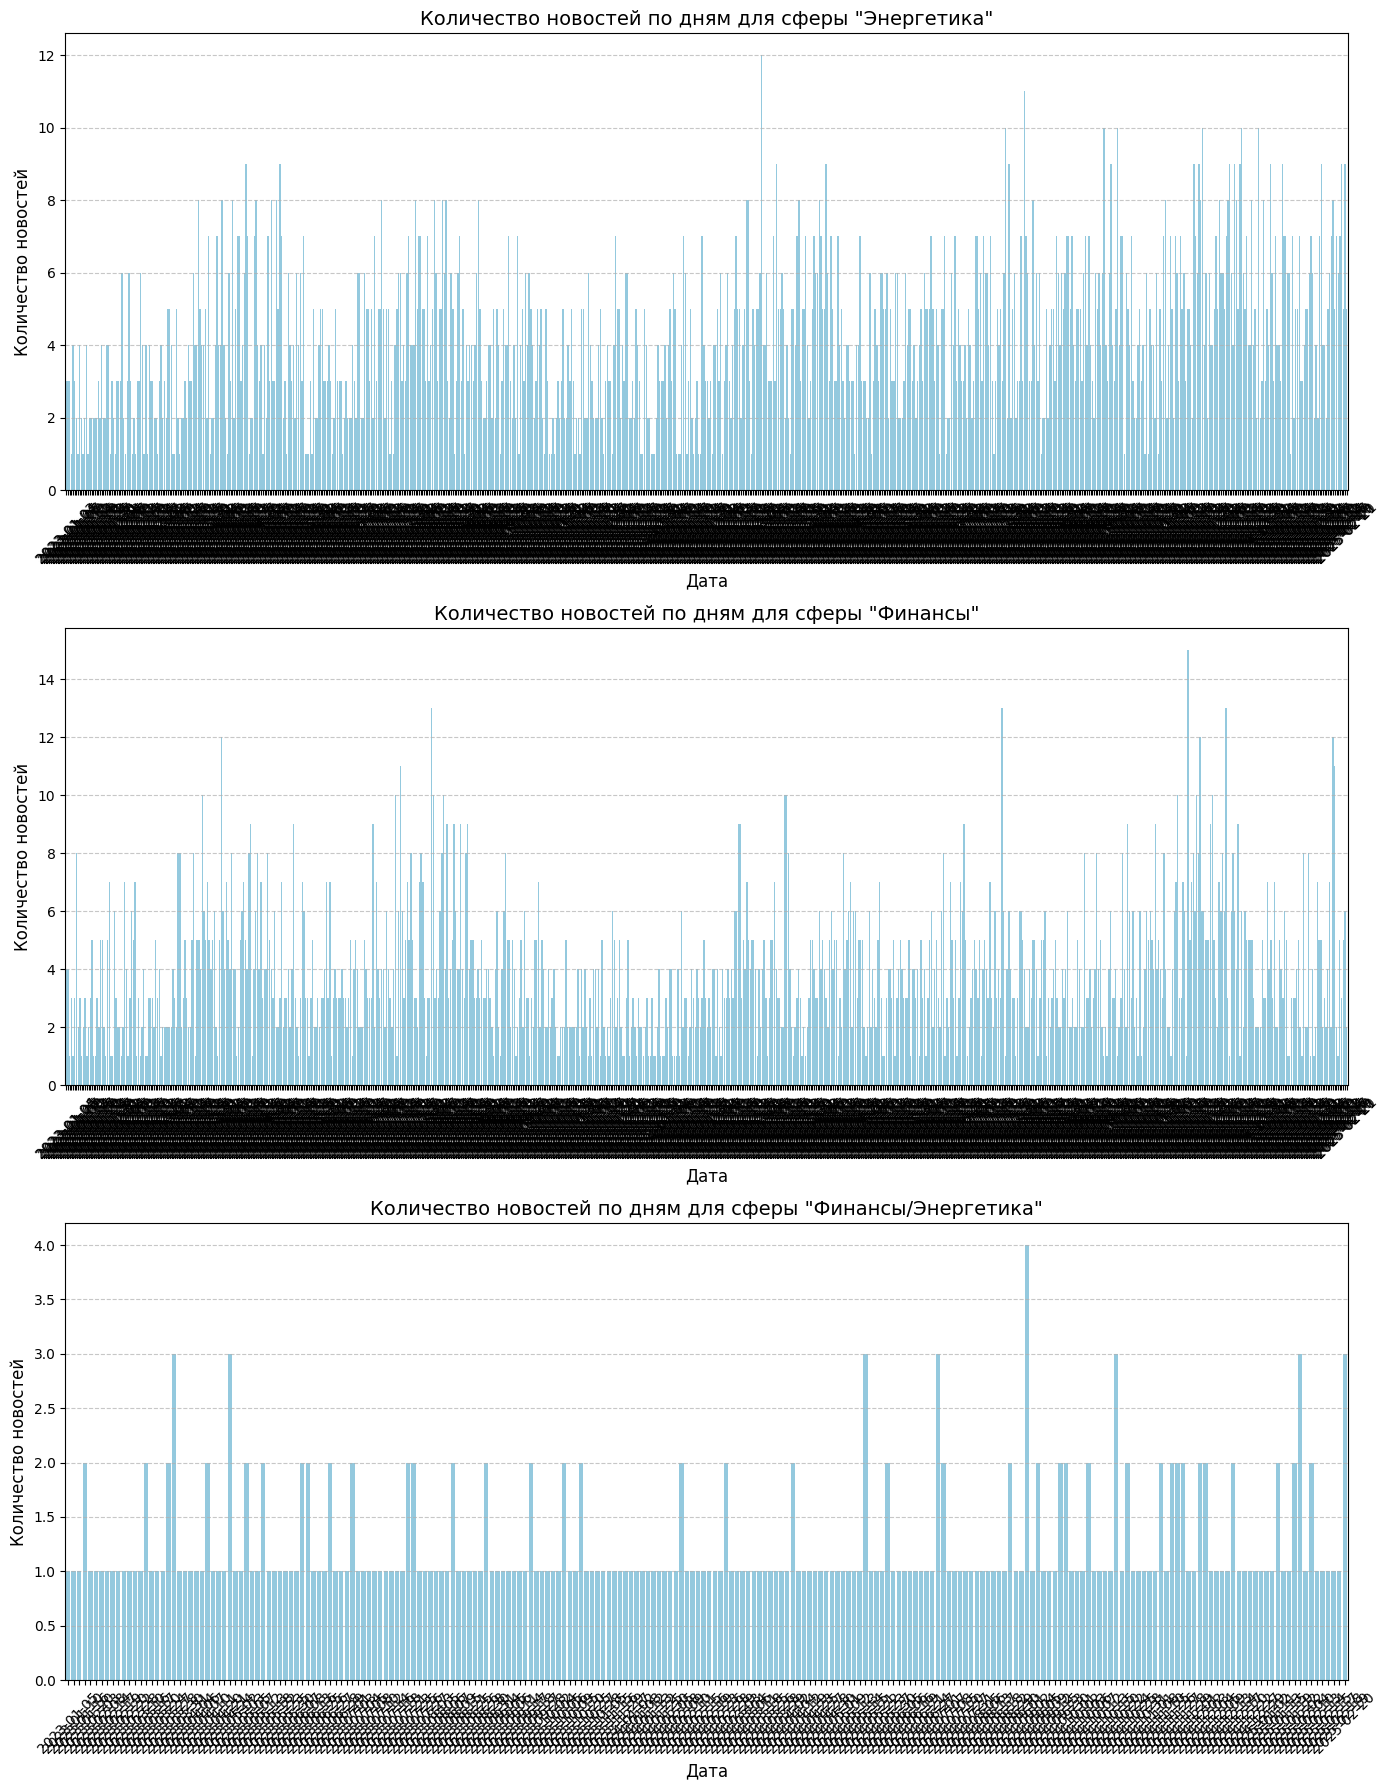

In [17]:
news_data['date'] = news_data['datetime'].dt.date 
spheres = news_data['sphere'].unique()

plt.figure(figsize=(14, 6 * len(spheres))) 

for i, sphere in enumerate(spheres, 1):
    plt.subplot(len(spheres), 1, i) 
    sphere_data = news_data[news_data['sphere'] == sphere]
    
    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Выводим даты для максимума по новостям

    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Находим дату с максимальным количеством новостей
    max_date = grouped_data.loc[grouped_data['count'].idxmax(), 'date']

    print(f"Дата с максимальным количеством новостей для сферы '{sphere}': {max_date}")

    
    sns.barplot(x='date', y='count', data=grouped_data, color='skyblue')
    plt.title(f'Количество новостей по дням для сферы "{sphere}"', fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Количество новостей', fontsize=12)
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

Выполним аналогичную операцию с webnews

Дата с максимальным количеством новостей для сферы 'Финансы': 2024-11-29
Дата с максимальным количеством новостей для сферы 'Энергетика': 2025-01-15
Дата с максимальным количеством новостей для сферы 'Финансы/Энергетика': 2025-02-14


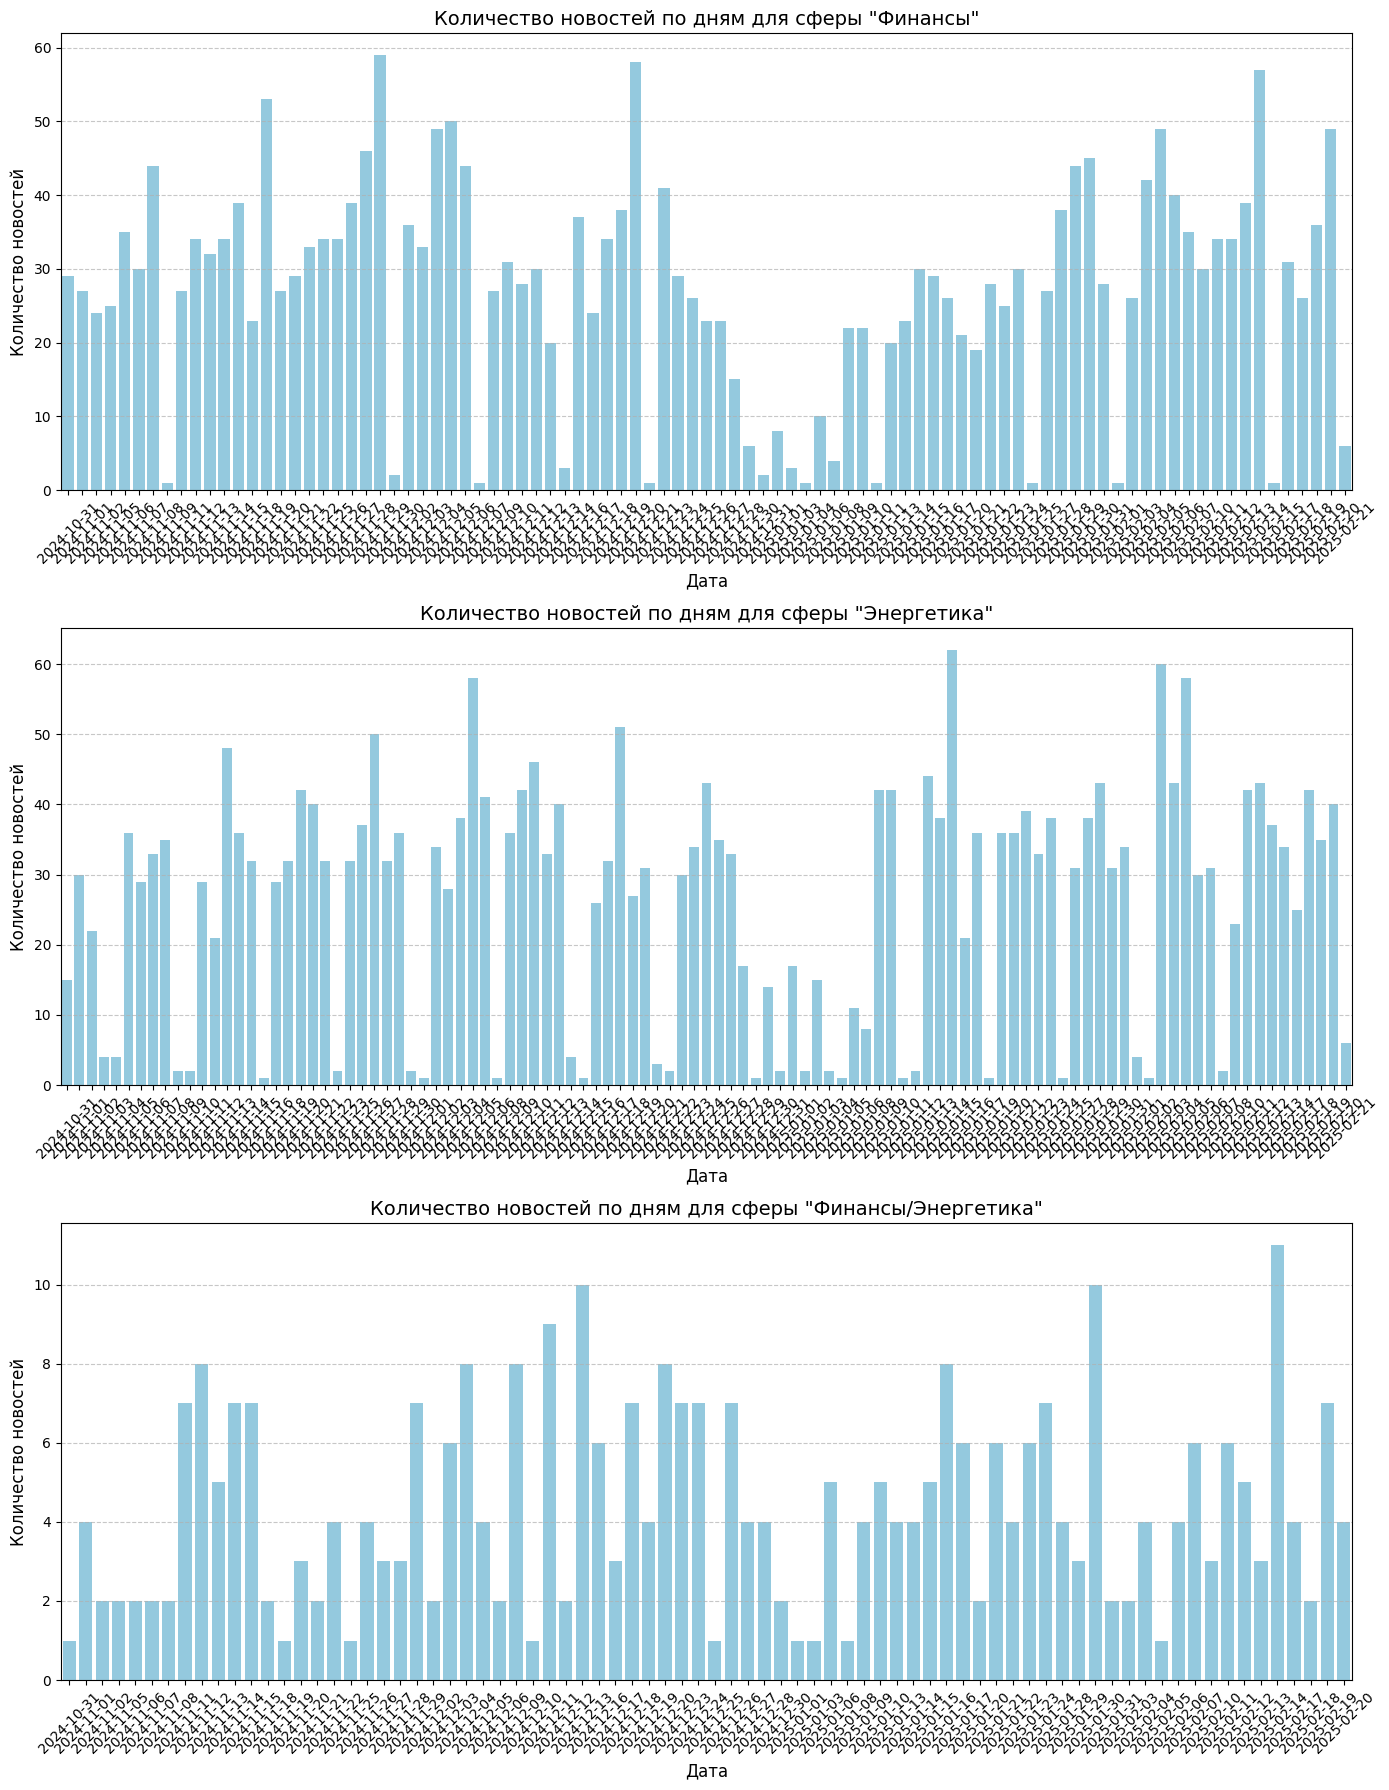

In [18]:
webnews_data['date'] = webnews_data['datetime'].dt.date 
spheres = webnews_data['sphere'].unique()

plt.figure(figsize=(14, 6 * len(spheres))) 

for i, sphere in enumerate(spheres, 1):
    plt.subplot(len(spheres), 1, i) 
    sphere_data = webnews_data[webnews_data['sphere'] == sphere]
    
    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Выводим даты для максимума по новостям

    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Находим дату с максимальным количеством новостей
    max_date = grouped_data.loc[grouped_data['count'].idxmax(), 'date']

    print(f"Дата с максимальным количеством новостей для сферы '{sphere}': {max_date}")

    
    sns.barplot(x='date', y='count', data=grouped_data, color='skyblue')
    plt.title(f'Количество новостей по дням для сферы "{sphere}"', fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Количество новостей', fontsize=12)
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

Теперь объединим новости с флагом 

1 - для новостей из интернета

0 - для новостей из telegram

In [19]:
webnews_data['web'] = [1] * len(webnews_data)
news_data['web'] = [0] * len(news_data)
news = pd.concat([webnews_data, news_data], ignore_index=True)

In [20]:
news.head()

,title,datetime,article_text,source,sphere,date,web
0,Rivian в IV квартале сократил чистый убыток вд...,2025-02-21 10:58:00,Москва. 21 февраля. INTERFAX.RU - Американски...,Интерфакс,Финансы,2025-02-21,1
1,"Стартовала всероссийская акция ""Газпрома"", пос...",2025-02-21 10:52:00,Москва. 21 февраля. INTERFAX.RU - Село Майма ...,Интерфакс,Финансы,2025-02-21,1
2,"""Распадская"" завершила 2024 год с убытком, EBI...",2025-02-21 10:34:00,"Москва. 21 февраля. INTERFAX.RU - ПАО ""Распад...",Интерфакс,Финансы,2025-02-21,1
3,В начале основной сессии индексы МосБиржи и РТ...,2025-02-21 10:15:00,Москва. 21 февраля. INTERFAX.RU - Российский ...,Интерфакс,Энергетика,2025-02-21,1
4,"Рубль на ""Мосбирже"" заметно дорожает к юаню",2025-02-21 10:12:00,"Москва. 21 февраля. INTERFAX.RU - На ""Московс...",Интерфакс,Энергетика,2025-02-21,1


Построим аналогичный график для news

Дата с максимальным количеством новостей для сферы 'Финансы': 2025-02-14
Дата с максимальным количеством новостей для сферы 'Энергетика': 2025-01-15
Дата с максимальным количеством новостей для сферы 'Финансы/Энергетика': 2025-02-14


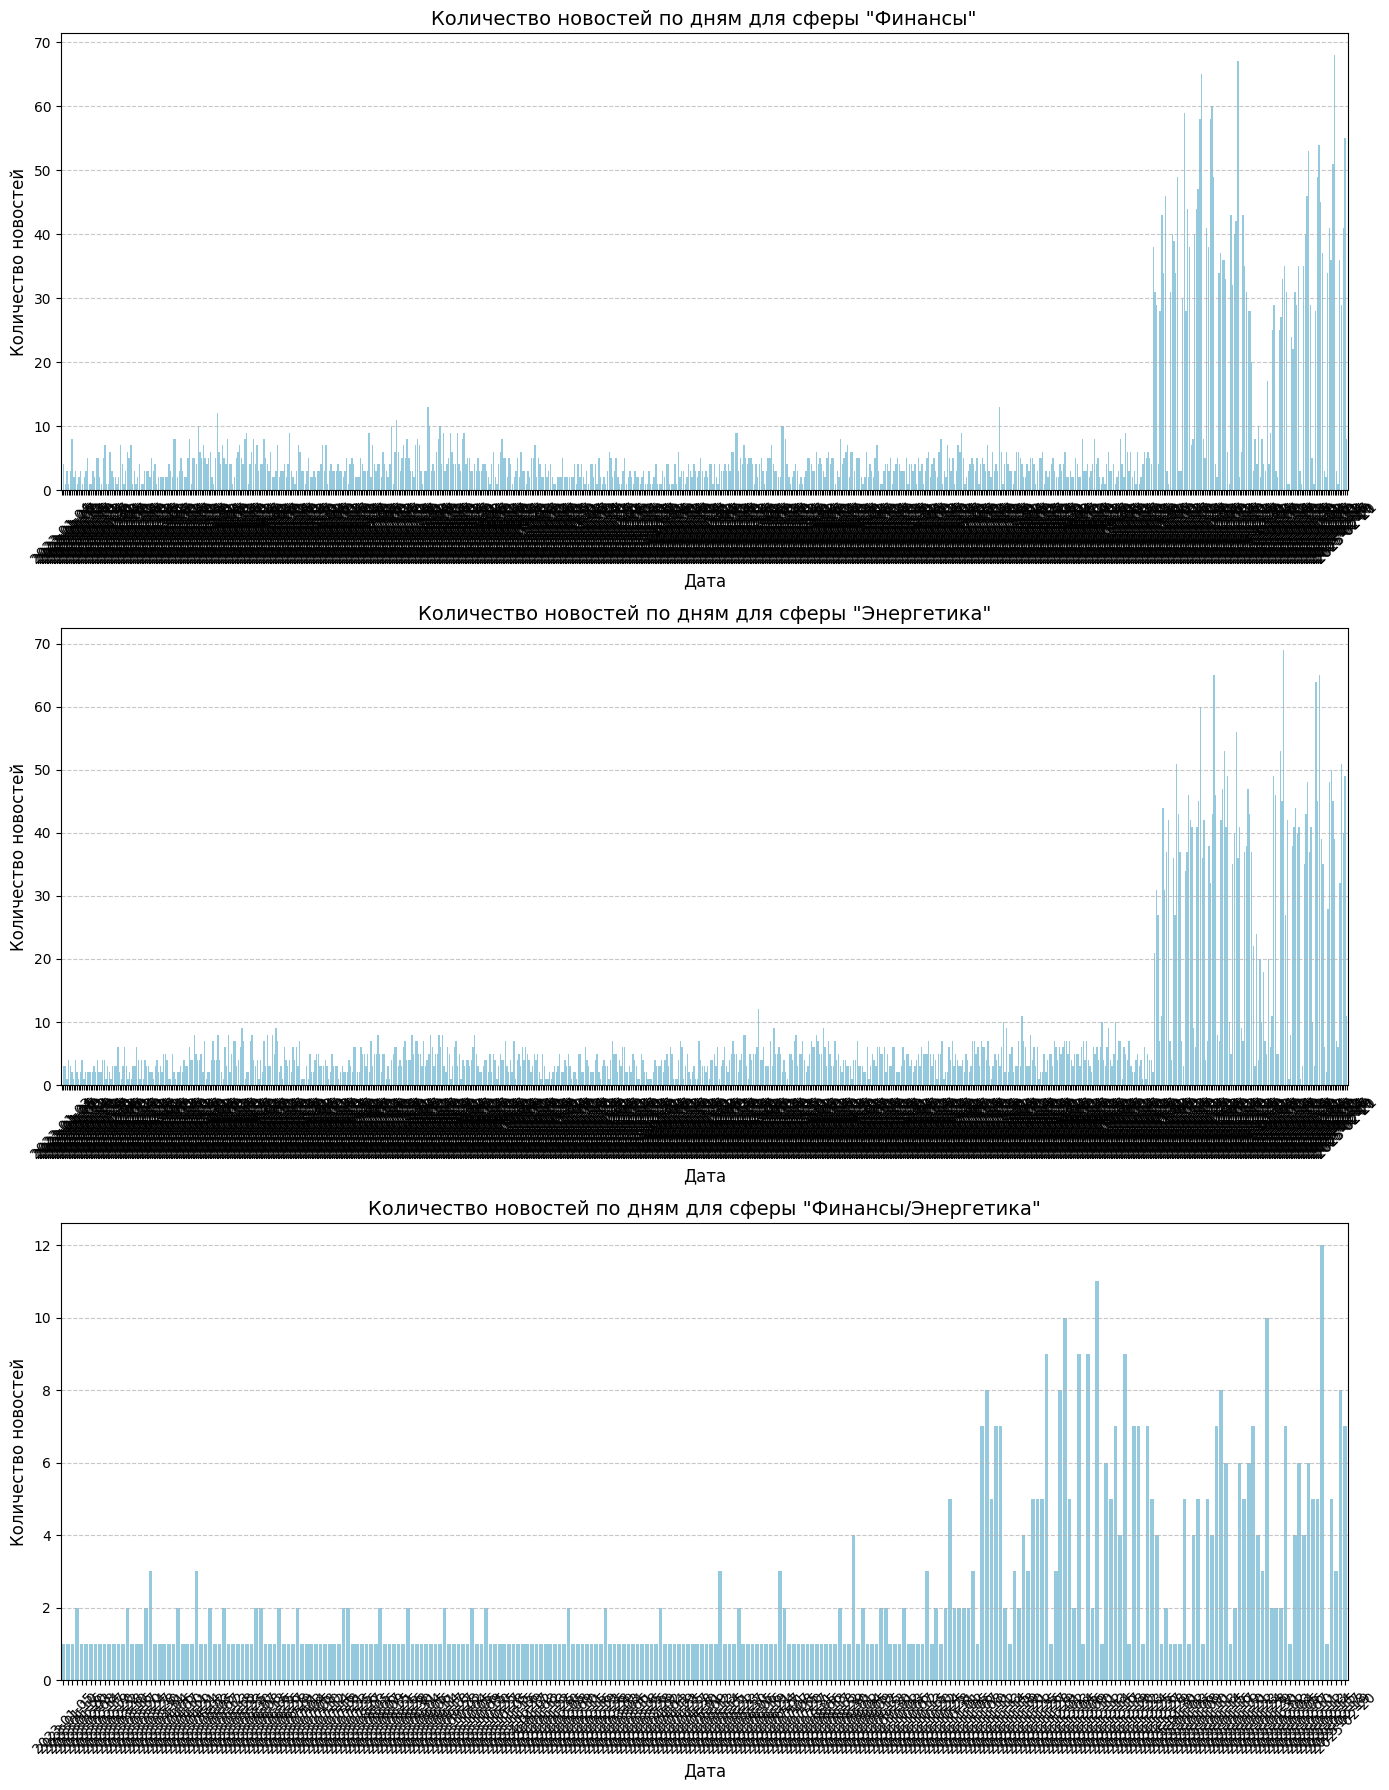

In [21]:
news['date'] = news['datetime'].dt.date 
spheres = news['sphere'].unique()

plt.figure(figsize=(14, 6 * len(spheres))) 

for i, sphere in enumerate(spheres, 1):
    plt.subplot(len(spheres), 1, i) 
    sphere_data = news[news['sphere'] == sphere]
    
    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Выводим даты для максимума по новостям

    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Находим дату с максимальным количеством новостей
    max_date = grouped_data.loc[grouped_data['count'].idxmax(), 'date']

    print(f"Дата с максимальным количеством новостей для сферы '{sphere}': {max_date}")

    
    sns.barplot(x='date', y='count', data=grouped_data, color='skyblue')
    plt.title(f'Количество новостей по дням для сферы "{sphere}"', fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Количество новостей', fontsize=12)
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

## Разметка данных

Для корректной разметки выведем по 2 примера новостей для каждой из сфер

In [22]:
print(news[news['sphere'] == "Финансы"][4:5]['article_text'][8])
print(news[news['sphere'] == "Финансы"][5:6]['article_text'][9])

print(news[news['sphere'] == "Финансы/Энергетика"][:1]['article_text'][30])
print(news[news['sphere'] == "Финансы/Энергетика"][1:2]['article_text'][57])

print(news[news['sphere'] == "Энергетика"][:1]['article_text'][3])
print(news[news['sphere'] == "Энергетика"][1:2]['article_text'][4])

 Москва. 21 февраля. INTERFAX.RU - Американская Booking Holdings, оператор онлайн-сервисов для планирования путешествий, увеличила чистую прибыль в четвертом квартале 2024 года почти в пять раз, выручку - на 14%, причем скорректированная прибыль и выручка оказались лучше прогнозов рынка. Как говорится в пресс-релизе компании, чистая прибыль в октябре-декабре составила $1,07 млрд, или $31,95 в расчете на акцию, по сравнению с $222 млн, или $6,28 на акцию, за аналогичный период предыдущего года. Прибыль без учета разовых факторов составила $41,55 на акцию. Квартальная выручка Booking увеличилась на 14%, до $5,47 млрд. Эксперты, опрошенные FactSet, в среднем прогнозировали скорректированную прибыль компании на уровне $36,08 на акцию при выручке в $5,18 млрд. Валовой объем бронирований (без учета отмененных заказов) в минувшем квартале вырос на 17%. Число забронированных ночей повысилось на 13% - до 261 млн. Совет директоров Booking рекомендовал повысить квартальные дивиденды на 10%, до $9

Разметим данные по 100-бальной шкале

### Финансы 1
 Москва. 21 февраля. INTERFAX.RU - Американская Booking Holdings, оператор онлайн-сервисов для планирования путешествий, увеличила чистую прибыль в четвертом квартале 2024 года почти в пять раз, выручку - на 14%, причем скорректированная прибыль и выручка оказались лучше прогнозов рынка. Как говорится в пресс-релизе компании, чистая прибыль в октябре-декабре составила $1,07 млрд, или $31,95 в расчете на акцию, по сравнению с $222 млн, или $6,28 на акцию, за аналогичный период предыдущего года. Прибыль без учета разовых факторов составила $41,55 на акцию. Квартальная выручка Booking увеличилась на 14%, до $5,47 млрд. Эксперты, опрошенные FactSet, в среднем прогнозировали скорректированную прибыль компании на уровне $36,08 на акцию при выручке в $5,18 млрд. Валовой объем бронирований (без учета отмененных заказов) в минувшем квартале вырос на 17%. Число забронированных ночей повысилось на 13% - до 261 млн. Совет директоров Booking рекомендовал повысить квартальные дивиденды на 10%, до $9,6 на акцию. Дивиденды будут выплачены 31 марта акционерам из реестра на 7 марта. Акции Booking подорожали на 4,3% на дополнительных торгах в четверг. За последние 12 месяцев рыночная стоимость компании подскочила на 28,6%, до $169 млрд.


Результат: 3

Обоснование: Т.к. повысилась прибыль, это может свидетельствовать о подъеме глобального рынка, но так как компания американская, на рынке России это отразится в меньшей мере

### Финансы 2
 Москва. 21 февраля. INTERFAX.RU - ООО "Сибирские аэропорты" (входит в структуру ОК "Русал" , управляет аэропортами группы) увеличило уставный капитал на 1,2 млрд рублей - до 9,641 млрд рублей, сообщается в материалах ЕГРЮЛ. Соответствующие изменения произошли 20 февраля. Ранее уставный капитал компании составлял 8,441 млрд рублей. Почти 100% компании по-прежнему владеет МКОО "Гершвин". Компания "Сибирские аэропорты" (прежнее наименование - "Русал Аэро") выполняет функции управляющей компании аэропортов Новокузнецка и Братска, ООО "Тайшетаэро" (создано для строительства аэропорта в Тайшете Иркутской области, где у "Русала" расположен алюминиевый завод), АО "Аэропорт-Сервис" (один из операторов аэропорта Южно-Сахалинска), ООО "Капитал-Авиа" (Южно-Сахалинск, занимается транспортной обработкой грузов). В мае 2024 года "Русал Аэро" выступило учредителем ООО "Богучаны Аэро" с целью проработки проекта развития аэропортовой инфраструктуры на севере Красноярского края. В июле 2024 года ООО "Сибирские аэропорты" зарегистрировало в Иркутске дочернюю структуру ООО "Терминал Иркутск", в августе 2024 года - в Абакане (Хакасия) ООО "Терминал Абакан".

Результат: 6

Обоснование:  Т.к. повысилась прибыль, это может свидетельствовать о подъеме рынка страны, что может хорошо отразиться на банковской сфере. Однако эта новость никак не относится к банковскому делу, так что корреляция здесь близкая незначащей

## Финансы/Энергетика 1

 Москва. 20 февраля. INTERFAX.RU - Банк России расширил пул облигаций, доступных для неквалифицированных инвесторов без тестирования, сообщила пресс-служба регулятора. Теперь они могут приобретать корпоративные облигации с кредитным рейтингом "А+" и выше (за исключением облигаций, обеспеченных залогом денежных требований, в том числе ипотечных). Такие инструменты обладают высокой ликвидностью и имеют незначительную вероятность дефолта - в пределах 1,3%, отмечает ЦБ. "Таким образом, инвесторы будут в достаточной степени защищены от кредитного риска. Это повысит привлекательность долгового рынка для розничных инвесторов и позволит им формировать более сбалансированный инвестиционный портфель", - добавляется в сообщении ЦБ. Раньше "неквалам" без тестирования были доступны только облигации федерального займа, регионов (вне зависимости от уровня кредитного рейтинга) и другие долговые бумаги с фиксированным доходом, но с рейтингом не ниже "ААА".


Результат: 97

Обоснование: Данная новость сообщает о значительном подъеме фондового рынка России, что в равной степени затрагивает и финансы, и энергетику. Это влечет за собой прямое положительное влияние на фондовый рынок



## Финансы/Энергетика 2

 Москва. 20 февраля. INTERFAX.RU - "Яндекс" в 2025 году планирует продолжать наращивать численность своих сотрудников, сообщил представитель компании на онлайн-звонке для аналитиков и инвесторов по итогам IV квартала 2024 года. За год компания увеличила количество основного персонала на 15%, до 29 тысяч человек. "Мы не в этом поезде по увольнениям IT-сотрудников и их сокращений, мы планируем увеличить численность сотрудников в компании в 2025 году", - сказал он, не уточнив, на сколько может вырасти численность персонала. Компания продолжает инвестировать в развитие своих продуктов, сервисов и технологий и, соответственно, для такой траектории развития требуется привлечение новых талантливых сотрудников. "Мы способны, на самом деле, показывать и хороший операционный рычаг, и нанимать, и удерживать лучших людей", - добавил представитель. В конце 2024 года ряд СМИ и телеграм-каналов начали сообщать о планируемых сокращениях в крупных IT-компаниях. По данным их собеседников, некоторые компании тогда уже начали оптимизацию штата, а другие рассматривают возможность увольнений из-за высокой стоимости сотрудников на фоне возросших процентных ставок.

Результат: -8

Обоснование: Новость не влечет за собой непосредственный рост или же понижение цен акций. Однако мы можем заметить, что в ней говорится, о сокращениях в IT-компаниях, следовательно, это показывает уменьшение бюджета, выделяемого на инновации, это может быть причиной падения акций


## Энергетика 1

 Москва. 21 февраля. INTERFAX.RU - Российский рынок акций в начале основной сессии на "Мосбирже" в пятницу растет на сохраняющихся ожиданиях снижения геополитических рисков на фоне начавшегося диалога между Россией и США; при этом внешние фондовые площадки подают смешанные сигналы, умеренно проседает нефть (фьючерс на Brent торгуется ниже $76,5 за баррель). Индексы МосБиржи и РТС за минуту основных торгов выросли на 0,6%, лидерами роста выступают акции "Татнефти" (+1,9%), АФК "Система" (+1,8%), "Русала" (+1,8%). К 10:01 индекс МосБиржи вырос на 0,6% до 3310,79 пункта, индекс РТС вырос на 0,6% до 1178,36 пункта; цены большинства "голубых фишек" на "Мосбирже" выросли в пределах 1,6%. Официальный курс доллара США, установленный Банком России с 21 февраля, составляет 88,5103 рубля (-1,92 рубля). Подорожали также акции "Магнита" (+1,6%), "Аэрофлота" (+1,5%), "Газпром нефти" (+1,2%), "Сургутнефтегаза" (+0,9%), "НОВАТЭКа" (+0,9%), "Московской биржи" (+0,7%), "МТС" (+0,7%), "АЛРОСА" (+0,6%), "Газпрома" (+0,6%), "Роснефти" (+0,6%), "ЛУКОЙЛа" (+0,4%), "НЛМК" (+0,4%), "ММК" (+0,3%), "Интер РАО" (+0,3%), "Т-Технологий" (+0,2%), Сбербанка (+0,1% и +0,1% "префы"), "Северстали" (+0,1%), "Норникеля" (+0,1%), "РусГидро" (+0,1%). Подешевели акции ВТБ (-0,3%), ПАО "Полюс" (-0,3%), "префы" "Сургутнефтегаза" (-0,1%). Суммарный объем торгов акциями из расчета индекса МосБиржи к 10:01 составил 8,75 млрд рублей (из них 1,21 млрд рублей пришлось на акции "Газпрома", 810,53 млн рублей на бумаги ВТБ и 604,7 млн рублей на акции "Т-Технологий"). Возможность проведения встречи президентов США и России Дональда Трампа и Владимира Путина будет зависеть от того, какой прогресс будет достигнут на переговорах по урегулированию ситуации на Украине, заявил госсекретарь США Марко Рубио. Соединенные Штаты выступили против того, чтобы в связанном с третьей годовщиной начала СВО на Украине заявлении G7 Россия называлась агрессором, сообщает The New York Times со ссылкой на высокопоставленных чиновников. "Представители администрации Трампа указали, что они хотели бы чего-то иного и более краткого, чем заявление, сделанное при бывшем президенте Джо Байдене, и стремились к тому, чтобы оно не мешало и не блокировало переговоры, которые сейчас ведутся с Россией", - говорится в публикации. В результате был подготовлен проект заявления, "в котором не упоминается ни Россия как агрессор, ни Украина как жертва вторжения". В нем указывается, что "надежные гарантии безопасности и интеграция Украины в Европейский союз будут иметь решающее значение для обеспечения прочного мира, который предотвратит будущую агрессию". Как пишет издание, разработка проекта документа может продолжаться до понедельника, когда заявление будет опубликовано. Президент США Дональд Трамп заявил, что угрожал странам БРИКС 150-процентными пошлинами в том случае, если они хотя бы упомянут об "уничтожении доллара". "Что касается БРИКС. (...) Они собирались создать новую валюту; они, возможно, хотели использовать юань. (...) (Экс-президент США Джо) Байден сказал, что это сложная ситуация. (...) Первое, что я сказал: любая страна БРИКС, которая упомянет об уничтожении доллара, будет обложена тарифами в 150%", - заявил Трамп на встрече с губернаторами-республиканцами. Еще он заявил, что введение пошлин на импорт может привести к полному отказу от подоходного налога в стране. "Мы могли бы полностью отменить подоходный налог. Возможно, нам вообще не потребуется система подоходного налогообложения, когда все это сработает", - отметил он. Ранее Трамп заявлял, что страны БРИКС в случае создания своей валюты и отказа от использования во взаиморасчетах американского доллара ждут 100-процентные тарифы на ввоз товаров в США. По его словам, "нет никаких шансов, что БРИКС заменит доллар США в международной торговле", при этом любая страна, которая попытается это сделать, "должна поприветствовать пошлины и попрощаться с Америкой". Как отмечают аналитики компании "Цифра брокер", индекс рыночной волатильности (RVI) в четверг отступил до недельных минимумов, отражая дальнейшее снижение рыночных опасений. Тем не менее значение индекса все еще остается на относительно высоких уровнях (около 40 пунктов), что указывает на отсутствие рыночной эйфории, несмотря на рост фондовых индексов с начала года на 14-31%. Это благоприятная для рынка конфигурация, которая позволяет надеяться на продолжение восходящей динамики фондовых индексов в краткосрочной перспективе, полагают эксперты. Начальник отдела экономического и отраслевого анализа Промсвязьбанка Евгений Локтюхов ожидает, что индекс МосБиржи в пятницу останется в диапазоне 3270-3310 пунктов, продолжив консолидацию у локальных максимумов в ожидании новых вводных. Учитывая новостные риски предстоящих выходных, сильных движений рынок акций в пятницу может не показать, считает аналитик. Руководитель направления инвестиционного консультирования компании "Алор брокер" Алексей Антонов также полагает, что рынку акций нужны новые драйверы для продолжения роста. Отметка 3300 пунктов по индексу МосБиржи выступает сопротивлением, которое на неделе было протестировано на всеобщей эйфории о возможности скорого прекращения огня на Украине и ослабления антироссийских санкций. Однако не стоит закладываться на то, что уверенный пробой уровня произойдет в ближайшее время. "Позитивные заявления из-за океана уже не приводят к агрессивным покупкам, нужны какие-то конкретные шаги. Если их не последует, то может сработать старое правило: если рынок не хочет расти, то он будет снижаться. На дневном графике индекса МосБиржи присутствует довольно сильный незакрытый "гэп" от 13 февраля. Так что провал рынка в район чуть выше 3000 пунктов выглядит очень вероятным. И это может быть отличной возможностью для новых покупок акций", - считает Антонов. В США индексы акций в четверг снизились на 0,4-1% во главе с Dow, участники рынка оценивали заявления президента США Дональда Трампа о новых пошлинах. Трамп накануне подтвердил, что объявит о новых пошлинах в следующем месяце или даже раньше, и добавил древесину и пиломатериалы к списку товаров, ввоз которых в Штаты будет облагаться тарифами. Также трейдеры оценивают протокол январского заседания Федеральной резервной системы (ФРС), по итогам которого базовая процентная ставка была оставлена на уровне 4,25-4,5% годовых. Как следует из протокола, руководители ФРС выразили обеспокоенность тем, что импортные пошлины и другие экономические планы Трампа могут замедлить процесс возвращения инфляции к целевому уровню в 2%. Участники январского заседания Федрезерва ясно дали понять, что "хотели бы увидеть дальнейший прогресс в борьбе с инфляцией, прежде чем вносить дополнительные коррективы в целевой диапазон ставки". Они полагают, что им может "потребоваться время" для оценки меняющихся перспектив, говорится в протоколе. В Азии в пятницу преобладает позитивная динамика индексов акций (японский индекс Nikkei 225 подрос на 0,3%, австралийский ASX Australia просел на 0,4%, южнокорейский Kospi прибавил 0,02%, китайский Shanghai Composite вырос на 0,8%, гонконгский Hang Seng прибавляет 3,5%), стабильны американские фондовые фьючерсы (контракты на индексы изменяются менее чем на 0,1%). Банк Японии готов увеличить объемы закупок гособлигаций, если долгосрочные процентные ставки резко вырастут, заявил в парламенте глава ЦБ Кадзуо Уэда. Он отметил, что банк будет оперативно действовать в случае необходимости, чтобы обеспечить стабильное формирование доходности. Потребительские цены в Японии в январе увеличились на 4% в годовом выражении, согласно официальным данным. Таким образом, инфляция ускорилась по сравнению с 3,6% в декабре и стала максимальной с января 2023 года. Цены без учета свежих продуктов питания (ключевой показатель, отслеживаемый Банком Японии) повысились на 3,2%, продемонстрировав самый существенный подъем с июня 2023 года. Опрошенные Trading Economics аналитики в среднем прогнозировали повышение на 3,1% после роста на 3% в декабре. На нефтяном рынке утром в пятницу цены умеренно снижаются после роста накануне. К 10:01 по Москве апрельские фьючерсы на Brent дешевели на 0,3% до $76,28 за баррель (+0,6% в четверг), апрельские фьючерсы на WTI дешевели на 0,2% до $72,3 за баррель (+0,5% накануне). По данным Минэнерго США, коммерческие запасы нефти в стране на прошлой неделе увеличились на 4,63 млн баррелей. Эксперты ожидали роста на 3 млн баррелей. Товарные запасы бензина снизились на 151 тысячу баррелей, дистиллятов - упали на 2,05 млн баррелей. Аналитики прогнозировали сокращение запасов бензина на 1 млн баррелей, дистиллятов - на 1,5 млн баррелей. Минэнерго США сообщило, что импорт нефти сократился на 488 тысяч. баррелей в сутки, а экспорт вырос на 472 тысячи б/с, что в совокупности дает отток в размере 960 тысяч баррелей в сутки, или 6,72 млн баррелей за минувшую неделю. Поддержку ценам на нефть также оказали новости о наступлении холодов в США, из-за которых добыча нефти в стране может сократиться на 120-150 тысяч баррелей в сутки. Добыча природного газа также могла уменьшиться, отмечают эксперты ING. По их мнению, проблемы с добычей продлятся как минимум до наступления выходных, когда на севере страны ожидается потепление. Вице-премьер Александр Новак на совещании о ситуации на рынке нефтепродуктов поддержал решение о введении запрета экспорта бензина для не производящих его компаний на период с 1 марта по 31 августа 2025 года с целью балансировки рынка в период повышенного спроса. Как сообщает пресс-служба правительства, нефтеперерабатывающим заводам и владеющим ими нефтяным компаниям экспорт топлива будет разрешен. Таким образом, продлевается разрешение на экспорт бензина для его производителей и запрет для остальных, действующие в настоящее время. Ранее Федеральная антимонопольная служба поднимала вопрос о полном запрете экспорта бензинов для всех категорий.


Результат: -80 

Обоснование: В данной статье говорится о падении цен на нефть, что имеет прямую негативную корреляцию цен акций промышленности

## Энергетика 2

 Москва. 21 февраля. INTERFAX.RU - На "Московской бирже" утром в пятницу рубль дорожает к юаню в рамках подготовки экспортеров к налоговым выплатам февраля. В моменте юань дешевел до 11,907 рубля впервые с 29 августа 2024 года. За первую минуту торгов юань подешевел на 7,95 копейки до 11,9385 рубля. При этом юань оказался на 18,67 копейки ниже уровня действующего официального курса. "Драйвером укрепления рубля в четверг стали спекулятивные продажи валюты на фоне стремительно растущих ожиданий по снижению геополитических издержек, а также рост активности экспортеров перед февральскими налоговыми выплатами, которые необходимо произвести до конца следующей недели. Считаем, что тренд к укреплению рубля сохранится. Мы оцениваем курс, очищенный от геополитической надбавки, на уровне 85-87 рублей/$1 и 11,5-11,7 рубля/юань. Полагаем, что в ближайшее время вблизи этих значений может произойти стабилизация котировок", - отмечает управляющий эксперт Центра аналитики и экспертизы ПСБ Денис Попов. Цены на нефть слабо снижаются утром в пятницу после умеренного роста по итогам предыдущей сессии. К 10:08 по Москве апрельские фьючерсы на Brent дешевели на лондонской бирже ICE Futures на 0,24% до $76,3 за баррель. Апрельские фьючерсы на WTI к этому времени дешевели на бирже NYMEX на 0,26%, до $72,3 за баррель. По данным Минэнерго США, коммерческие запасы нефти в стране на прошлой неделе увеличились на 4,63 млн баррелей. Эксперты ожидали роста на 3 млн баррелей. Данные Минэнерго показали, что импорт нефти в США сократился на 488 тысяч баррелей в сутки, а экспорт вырос на 472 тысячи б/с, что в совокупности дает отток в размере 960 тысяч баррелей в сутки, или 6,72 млн баррелей за минувшую неделю.


Результат: -64

Обоснование: В данной статье упоминается снижение цен на нефть из-за геополитической обстановки, это может послужить причиной падения цен на акции компаний, связанных с энергетикой. Но также упоминается предыдущий рост, так что влияние на цену акций не критичное. Однако оно существенно, если рассматривать цену акций относительно предыдущих торгов


инициализируем промпт:

In [23]:
system_prompt = '''
# Инструкция для разметки влияния статьи на стоимость акций

# Твои ответы должны быть в формате JSON. Только JSON и ничего больше. Все твои рассуждения должны быть внутри JSON по структуре, описанной ниже
**Задача:**  
Проанализируйте текст статьи и определите, насколько она влияет на стоимость акций компаний в сфере, соответствующей теме статьи.  
Ответ предоставьте в формате JSON с полями:
```
{
  "reasoning": "(рассуждения модели на русском языке)",
  "answer": "(число от -100 до 100)"
}
```

## Правила оценки:


### Тема статьи:

    Определите отрасль/сферу (например, Финансы, Энергетика, IT и т.д.).

    Учитывайте только компании из этой отрасли.

    Если статья затрагивает несколько отраслей, оценивайте каждую отдельно (пример: Финансы/Энергетика).

### Факторы влияния:

    Прямое упоминание финансовых показателей (прибыль, убытки, инвестиции).

    Изменение регулирования/законов (например, решения ЦБ, санкции).

    Геополитические события (санкции, переговоры, конфликты).

    Динамика ключевых рынков (нефть, газ, фондовые индексы).

    Косвенные факторы (например, рост IT-компаний может влиять на банковский сектор).

### Шкала оценки:

    +100: Максимально положительное влияние (например, резкий рост нефти для энергетики).

    -100: Максимально негативное влияние (например, обвал рынка из-за санкций).

    0: Нейтральное или незначимое влияние.

## Примеры:

### Пример 1:

**Текст статьи:**

"Booking Holdings увеличила чистую прибыль в 4 квартале 2024 года почти в пять раз. Акции компании подорожали на 4,3%."

**Результат:**

```{
  "reasoning": "Рост прибыли и стоимости акций указывает на позитив для компании, но влияние на российский рынок ограничено (компания американская).",
  "answer": 3
}```

### Пример 2:

**Текст статьи:**

```{
  "reasoning": "Решение повысит ликвидность долгового рынка, что напрямую стимулирует финансовый сектор.",
  "answer": 97
}```

### Пример 3:

Результат:

```
{
  "reasoning": "Падение нефти негативно влияет на энергетический сектор, снижение индекса подтверждает рыночную реакцию.",
  "answer": -80
}
```

## Ваша задача:

Проанализируйте предоставленную статью и заполните JSON-ответ строго по инструкции.

Учитывайте:

    Точность определения отрасли.

    Логичность связи между содержанием статьи и оценкой.

    Отсутствие субъективных предположений вне текста.

    Тема статьи также влияет навашу оценку.

    
Напоминаю про структуру:

```
{
  "reasoning": "(рассуждения модели на русском языке)",
  "answer": "(число от -100 до 100)"
}
```

'''




Инициализируем модель

In [24]:

llm = Ollama(model="gemma2:27b", temperature=0)

def analyze_article_with_ollama(theme, article):
    prompt = f"{system_prompt}\n\nТема статьи: {theme}\n\nСтатья для анализа: {article}\n\nОтвет:"
    
    response = llm.generate([prompt])  
    try:
        return json.loads(response.generations[0][0].text.replace('json', '').split('```')[1])
    except Exception as e:
        return {'reasoning': '', 'answer': 0}



C:\Users\Ivan\AppData\Local\Temp\ipykernel_5992\558150846.py:1: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="gemma2:27b", temperature=0)


Разметим все данные

In [25]:

def row_analysing(row):
    with open('../data/model_data/model_data_cache.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    for i in data:
        if i['article_text'] == row['article_text']:
            print('m')
            return 
    result = analyze_article_with_ollama(row['sphere'], row['article_text'])
    result['article_text'] = row['article_text']
    result['sphere'] = row['sphere']
    result['source'] = row['source']
    result['date'] = str(row['date'])
    data.append(result)

    with open('../data/model_data/model_data_cache.json', 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

#news.apply(lambda x: row_analysing(x), axis=1)

Данные были размечены и хранятся в model_data_cache.json

## Обучение модели

Предобработка данных

In [176]:
with open('../data/model_data/model_data_cache.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
news_sentiment = pd.DataFrame(data)
news_sentiment

,reasoning,answer,article_text,sphere,source,date
0,"Статья о финансовых результатах Rivian, америк...",15.0,Москва. 21 февраля. INTERFAX.RU - Американски...,Финансы,Интерфакс,2025-02-21
1,"Статья рассказывает о социальной акции ПАО ""Га...",0.0,Москва. 21 февраля. INTERFAX.RU - Село Майма ...,Финансы,Интерфакс,2025-02-21
2,"Статья сообщает о значительном убытке ПАО ""Рас...",-75.0,"Москва. 21 февраля. INTERFAX.RU - ПАО ""Распад...",Финансы,Интерфакс,2025-02-21
3,,0.0,Москва. 21 февраля. INTERFAX.RU - Российский ...,Энергетика,Интерфакс,2025-02-21
4,"Статья фокусируется на динамике рубля и юаня, ...",25.0,"Москва. 21 февраля. INTERFAX.RU - На ""Московс...",Энергетика,Интерфакс,2025-02-21
...,...,...,...,...,...,...
10708,Введение налогов на криптовалюты и регулирован...,-20.0,**Турция планирует ввести налоги на криптоакти...,Финансы/Энергетика,The Экономист,2024-05-12
10709,"Статья о проблемах в сельском хозяйстве, вызва...",25.0,**Российские фермеры и сельхозкомпании на гран...,Энергетика,The Экономист,2024-05-11
10710,Статья рассказывает о финансовой связи Романа ...,10.0,**Абрамович все еще влияет на футбол в условия...,Финансы,The Экономист,2024-05-11
10711,Статья описывает случай мошенничества с исполь...,-30.0,**Более 26 миллионов рублей пропало со счетов ...,Финансы,The Экономист,2024-05-10


Удаляем reasoning, т.к. системная колонка

In [177]:
news_sentiment = news_sentiment[news_sentiment['reasoning'] != '']
news_sentiment.drop(columns=['reasoning'], inplace=True)
news_sentiment.dropna(inplace=True)
news_sentiment

C:\Users\Ivan\AppData\Local\Temp\ipykernel_5992\2073390580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_sentiment.drop(columns=['reasoning'], inplace=True)
C:\Users\Ivan\AppData\Local\Temp\ipykernel_5992\2073390580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_sentiment.dropna(inplace=True)


,answer,article_text,sphere,source,date
0,15.0,Москва. 21 февраля. INTERFAX.RU - Американски...,Финансы,Интерфакс,2025-02-21
1,0.0,Москва. 21 февраля. INTERFAX.RU - Село Майма ...,Финансы,Интерфакс,2025-02-21
2,-75.0,"Москва. 21 февраля. INTERFAX.RU - ПАО ""Распад...",Финансы,Интерфакс,2025-02-21
4,25.0,"Москва. 21 февраля. INTERFAX.RU - На ""Московс...",Энергетика,Интерфакс,2025-02-21
5,25.0,Москва. 21 февраля. INTERFAX.RU - Арбитражный...,Финансы,Интерфакс,2025-02-21
...,...,...,...,...,...
10708,-20.0,**Турция планирует ввести налоги на криптоакти...,Финансы/Энергетика,The Экономист,2024-05-12
10709,25.0,**Российские фермеры и сельхозкомпании на гран...,Энергетика,The Экономист,2024-05-11
10710,10.0,**Абрамович все еще влияет на футбол в условия...,Финансы,The Экономист,2024-05-11
10711,-30.0,**Более 26 миллионов рублей пропало со счетов ...,Финансы,The Экономист,2024-05-10


In [178]:
news_sentiment['answer'] = news_sentiment['answer'].apply(float)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_5992\3605166926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_sentiment['answer'] = news_sentiment['answer'].apply(float)


## Графики

таргет:

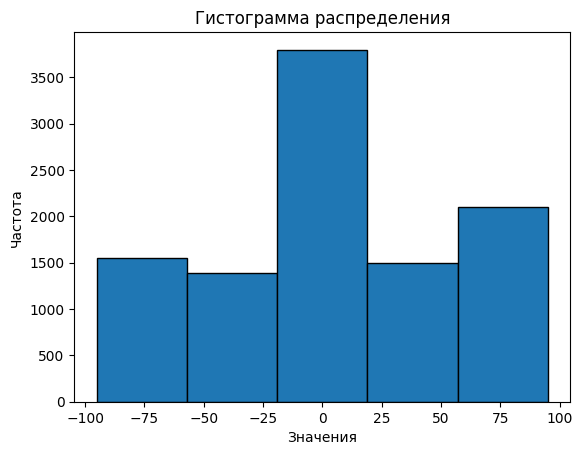

In [179]:
news_sentiment['answer'].plot.hist(bins=5, edgecolor='black')
plt.title('Гистограмма распределения')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

KDE

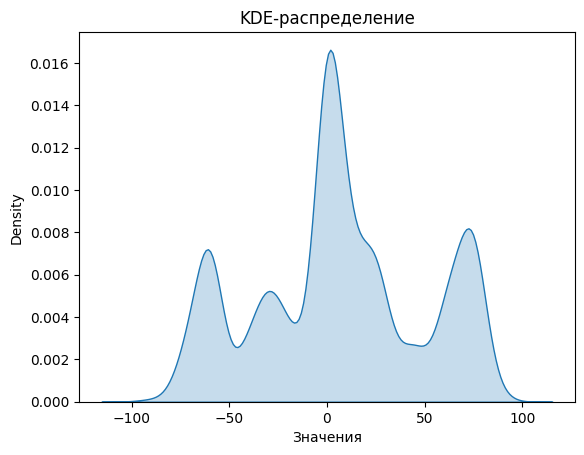

In [180]:
sns.kdeplot(news_sentiment['answer'], fill=True)
plt.title('KDE-распределение')
plt.xlabel('Значения')
plt.show()

## Предобработка

OHE сферы

In [181]:
news_sentiment

,answer,article_text,sphere,source,date
0,15.0,Москва. 21 февраля. INTERFAX.RU - Американски...,Финансы,Интерфакс,2025-02-21
1,0.0,Москва. 21 февраля. INTERFAX.RU - Село Майма ...,Финансы,Интерфакс,2025-02-21
2,-75.0,"Москва. 21 февраля. INTERFAX.RU - ПАО ""Распад...",Финансы,Интерфакс,2025-02-21
4,25.0,"Москва. 21 февраля. INTERFAX.RU - На ""Московс...",Энергетика,Интерфакс,2025-02-21
5,25.0,Москва. 21 февраля. INTERFAX.RU - Арбитражный...,Финансы,Интерфакс,2025-02-21
...,...,...,...,...,...
10708,-20.0,**Турция планирует ввести налоги на криптоакти...,Финансы/Энергетика,The Экономист,2024-05-12
10709,25.0,**Российские фермеры и сельхозкомпании на гран...,Энергетика,The Экономист,2024-05-11
10710,10.0,**Абрамович все еще влияет на футбол в условия...,Финансы,The Экономист,2024-05-11
10711,-30.0,**Более 26 миллионов рублей пропало со счетов ...,Финансы,The Экономист,2024-05-10


In [182]:
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Финансы'], ['Энергетика'], ['Финансы/Энергетика']]
enc.fit(X)
sphere_data = news_sentiment['sphere'].values.reshape(-1, 1)
encoded_sphere = enc.transform(sphere_data)
encoded_sphere_df = pd.DataFrame(encoded_sphere.toarray(), columns=enc.get_feature_names_out(['sphere']))
news_sentiment = pd.concat([news_sentiment, encoded_sphere_df], axis=1)


news_sentiment.drop('sphere', axis=1, inplace=True)
news_sentiment

,answer,article_text,source,date,sphere_Финансы,sphere_Финансы/Энергетика,sphere_Энергетика
0,15.0,Москва. 21 февраля. INTERFAX.RU - Американски...,Интерфакс,2025-02-21,1.0,0.0,0.0
1,0.0,Москва. 21 февраля. INTERFAX.RU - Село Майма ...,Интерфакс,2025-02-21,1.0,0.0,0.0
2,-75.0,"Москва. 21 февраля. INTERFAX.RU - ПАО ""Распад...",Интерфакс,2025-02-21,1.0,0.0,0.0
4,25.0,"Москва. 21 февраля. INTERFAX.RU - На ""Московс...",Интерфакс,2025-02-21,1.0,0.0,0.0
5,25.0,Москва. 21 февраля. INTERFAX.RU - Арбитражный...,Интерфакс,2025-02-21,0.0,0.0,1.0
...,...,...,...,...,...,...,...
5228,NaN,NaN,NaN,NaN,0.0,0.0,1.0
5243,NaN,NaN,NaN,NaN,1.0,0.0,0.0
5245,NaN,NaN,NaN,NaN,0.0,0.0,1.0
5255,NaN,NaN,NaN,NaN,1.0,0.0,0.0


In [183]:
news_sentiment.dropna(inplace=True)

OHE по источникам

In [184]:
# enc = OneHotEncoder(handle_unknown='ignore')
# X = [[i] for i in set(news_sentiment['source'])]
# enc.fit(X)
# sphere_data = news_sentiment['source'].values.reshape(-1, 1)
# encoded_sphere = enc.transform(sphere_data)
# encoded_sphere_df = pd.DataFrame(encoded_sphere.toarray(), columns=enc.get_feature_names_out(['source']))
# news_sentiment = pd.concat([news_sentiment, encoded_sphere_df], axis=1)


# news_sentiment.drop('source', axis=1, inplace=True)
# news_sentiment.dropna(inplace=True)
# news_sentiment


Предобработка текста

In [185]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

news_sentiment['article_text'] = news_sentiment['article_text'].apply(clean_text)
news_sentiment


,answer,article_text,source,date,sphere_Финансы,sphere_Финансы/Энергетика,sphere_Энергетика
0,15.0,москва февраля interfaxru американский прои...,Интерфакс,2025-02-21,1.0,0.0,0.0
1,0.0,москва февраля interfaxru село майма в респ...,Интерфакс,2025-02-21,1.0,0.0,0.0
2,-75.0,москва февраля interfaxru пао распадская за...,Интерфакс,2025-02-21,1.0,0.0,0.0
4,25.0,москва февраля interfaxru на московской бир...,Интерфакс,2025-02-21,1.0,0.0,0.0
5,25.0,москва февраля interfaxru арбитражный суд м...,Интерфакс,2025-02-21,0.0,0.0,1.0
...,...,...,...,...,...,...,...
10330,5.0,в россии резко вырос спрос на айтишников со зн...,The Экономист,2024-08-15,0.0,1.0,0.0
10331,0.0,милонов предложил вернуть в школах форму време...,The Экономист,2024-08-15,0.0,0.0,1.0
10332,-60.0,райффайзенбанк закрывает для россиян возможнос...,The Экономист,2024-08-15,1.0,0.0,0.0
10333,60.0,втб присоединит почта банк в году\n\nглава вт...,The Экономист,2024-08-15,1.0,0.0,0.0


Лемматизация

In [186]:

nlp = spacy.load("ru_core_news_sm")

def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.pos_ not in ["ADP", "CCONJ", "PART", "SCONJ", "PUNCT", "SYM"]]
    return ' '.join(lemmas)

news_sentiment['article_text'] = news_sentiment['article_text'].apply(lemmatize)

print(news_sentiment)

2025-03-17 20:44:40,580 - pymorphy3.opencorpora_dict.wrapper - INFO - Loading dictionaries from c:\Users\Ivan\PycharmProjects\CodeCats\.venv\Lib\site-packages\pymorphy3_dicts_ru\data
2025-03-17 20:44:40,607 - pymorphy3.opencorpora_dict.wrapper - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962


       answer                                       article_text  \
0        15.0    москва   февраль interfaxru   американский п...   
1         0.0    москва   февраль interfaxru   село майма рес...   
2       -75.0    москва   февраль interfaxru   пао распадская...   
4        25.0    москва   февраль interfaxru   московский бир...   
5        25.0    москва   февраль interfaxru   арбитражный су...   
...       ...                                                ...   
10330     5.0  россия резко вырасти спрос айтишник знание кит...   
10331     0.0  милонов предложить вернуть школа форма время р...   
10332   -60.0  райффайзенбанк закрывать россиянин возможность...   
10333    60.0  втб присоединить почта банк   год \n\n глава в...   
10334   -90.0  уральский физик предложить путин отрезать укра...   

              source        date  sphere_Финансы  sphere_Финансы/Энергетика  \
0          Интерфакс  2025-02-21             1.0                        0.0   
1          Интерфакс  202

Посмотрим WordCloud 

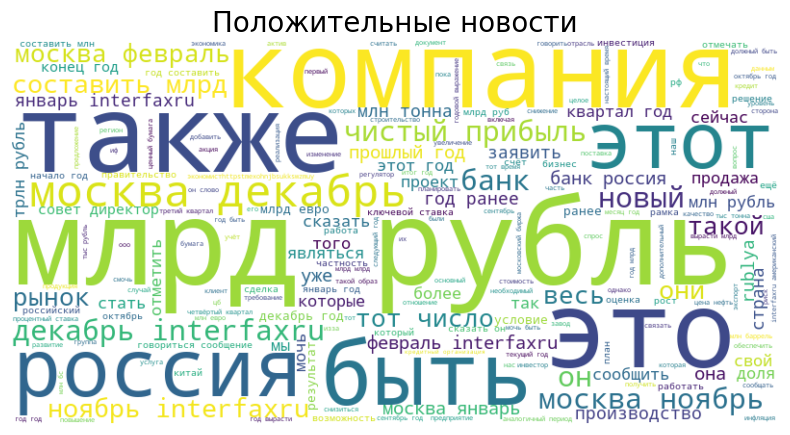

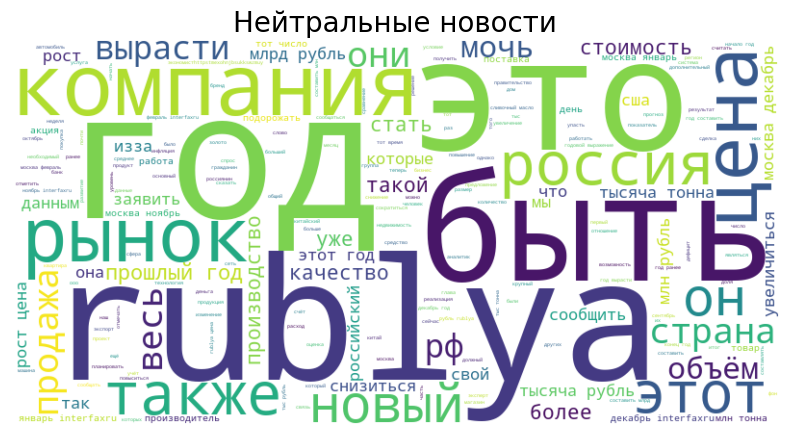

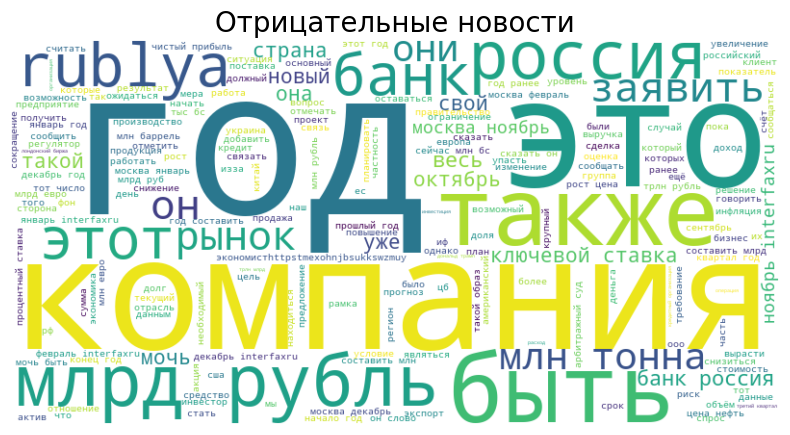

In [187]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=20)
    plt.show()

positive_text = ' '.join(news_sentiment[news_sentiment['answer'] > 0]['article_text'])
neutral_text = ' '.join(news_sentiment[news_sentiment['answer'] == 0]['article_text'])
negative_text = ' '.join(news_sentiment[news_sentiment['answer'] < 0 ]['article_text'])

plot_wordcloud(positive_text, 'Положительные новости')
plot_wordcloud(neutral_text, 'Нейтральные новости')
plot_wordcloud(negative_text, 'Отрицательные новости')

tf-idf

In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Униграммы и биграммы
tfidf_unigram = TfidfVectorizer(max_features=3000, ngram_range=(1, 1))
tfidf_bigram = TfidfVectorizer(max_features=2000, ngram_range=(2, 2))

# Векторизация
unigram_features = tfidf_unigram.fit_transform(news_sentiment['article_text'])
bigram_features = tfidf_bigram.fit_transform(news_sentiment['article_text'])

count_vec = CountVectorizer(max_features=1000)
count_features = count_vec.fit_transform(news_sentiment['article_text'])
news_sentiment['tokens'] = news_sentiment['article_text'].apply(lambda x: x.split())
# Признаки на основе статистик текста
news_sentiment['avg_word_length'] = news_sentiment['tokens'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)
news_sentiment['unique_words_ratio'] = news_sentiment['tokens'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
news_sentiment

,answer,article_text,source,date,sphere_Финансы,sphere_Финансы/Энергетика,sphere_Энергетика,tokens,avg_word_length,unique_words_ratio
0,15.0,москва февраль interfaxru американский п...,Интерфакс,2025-02-21,1.0,0.0,0.0,"[москва, февраль, interfaxru, американский, пр...",7.471429,0.735714
1,0.0,москва февраль interfaxru село майма рес...,Интерфакс,2025-02-21,1.0,0.0,0.0,"[москва, февраль, interfaxru, село, майма, рес...",6.891892,0.718919
2,-75.0,москва февраль interfaxru пао распадская...,Интерфакс,2025-02-21,1.0,0.0,0.0,"[москва, февраль, interfaxru, пао, распадская,...",7.108108,0.668919
4,25.0,москва февраль interfaxru московский бир...,Интерфакс,2025-02-21,1.0,0.0,0.0,"[москва, февраль, interfaxru, московский, бирж...",6.784884,0.732558
5,25.0,москва февраль interfaxru арбитражный су...,Интерфакс,2025-02-21,0.0,0.0,1.0,"[москва, февраль, interfaxru, арбитражный, суд...",6.974359,0.769231
...,...,...,...,...,...,...,...,...,...,...
10330,5.0,россия резко вырасти спрос айтишник знание кит...,The Экономист,2024-08-15,0.0,1.0,0.0,"[россия, резко, вырасти, спрос, айтишник, знан...",7.937500,0.895833
10331,0.0,милонов предложить вернуть школа форма время р...,The Экономист,2024-08-15,0.0,0.0,1.0,"[милонов, предложить, вернуть, школа, форма, в...",8.200000,0.900000
10332,-60.0,райффайзенбанк закрывать россиянин возможность...,The Экономист,2024-08-15,1.0,0.0,0.0,"[райффайзенбанк, закрывать, россиянин, возможн...",7.903846,0.923077
10333,60.0,втб присоединить почта банк год \n\n глава в...,The Экономист,2024-08-15,1.0,0.0,0.0,"[втб, присоединить, почта, банк, год, глава, в...",6.830508,0.830508


Тематическое моделирование

In [189]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_features = lda.fit_transform(count_features)

nmf = NMF(n_components=n_topics, random_state=42)
nmf_features = nmf.fit_transform(unigram_features)

lda_df = pd.DataFrame(lda_features, columns=[f'topic_lda_{i}' for i in range(n_topics)])
nmf_df = pd.DataFrame(nmf_features, columns=[f'topic_nmf_{i}' for i in range(n_topics)])
news_sentiment = pd.concat([news_sentiment.reset_index(drop=True), lda_df, nmf_df], axis=1)

def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: " + " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("LDA Topics:")
print_top_words(lda, tfidf_unigram.get_feature_names_out())

print("\nNMF Topics:")
print_top_words(nmf, tfidf_unigram.get_feature_names_out())

news_sentiment

LDA Topics:
Topic #0: wall дешеветь автоваз wti заботкин iv иена иметься инфраструктура возникнуть
Topic #1: автоваз игорь зависеть были италия gdr ипотека вернуться iv автозавод
Topic #2: gdr завод автоваз iv зона завершение гк вицепрезидент вицепремьер икра
Topic #3: весна автоваз гарантия издержка аграрий вон dax иметься iv bp
Topic #4: iv автоваз газотранспортный воспользоваться квартал квартальный занять задолженность биржевой вопрос
Topic #5: выгодный gmbh возникнуть intel альтернативный илья истечение их безусловно гг
Topic #6: инженерный илья задолженность holding их еврокомиссия бс вон dow квартира
Topic #7: возобновить автоваз завод весна дом здание dax trading ведущий канадский
Topic #8: carlsberg завершение ceo капиталь их завод заботкин вопрос завершить борьба
Topic #9: автоваз индонезия их возникнуть интерес завод totalenergies интересный зависеть водка

NMF Topics:
Topic #0: компания год быть он мы это ооо рынок этот проект
Topic #1: млрд прибыль акция выручка чистый ком

,answer,article_text,source,date,sphere_Финансы,sphere_Финансы/Энергетика,sphere_Энергетика,tokens,avg_word_length,unique_words_ratio,...,topic_nmf_0,topic_nmf_1,topic_nmf_2,topic_nmf_3,topic_nmf_4,topic_nmf_5,topic_nmf_6,topic_nmf_7,topic_nmf_8,topic_nmf_9
0,15.0,москва февраль interfaxru американский п...,Интерфакс,2025-02-21,1.0,0.0,0.0,"[москва, февраль, interfaxru, американский, пр...",7.471429,0.735714,...,0.006902,0.177071,0.011816,0.004955,0.000000,0.003031,0.000000,0.014100,0.005589,0.000000
1,0.0,москва февраль interfaxru село майма рес...,Интерфакс,2025-02-21,1.0,0.0,0.0,"[москва, февраль, interfaxru, село, майма, рес...",6.891892,0.718919,...,0.030911,0.000000,0.000445,0.000000,0.000000,0.000000,0.000000,0.000000,0.057702,0.000483
2,-75.0,москва февраль interfaxru пао распадская...,Интерфакс,2025-02-21,1.0,0.0,0.0,"[москва, февраль, interfaxru, пао, распадская,...",7.108108,0.668919,...,0.011989,0.086394,0.000000,0.000000,0.000000,0.001500,0.005384,0.110490,0.000000,0.000000
3,25.0,москва февраль interfaxru московский бир...,Интерфакс,2025-02-21,1.0,0.0,0.0,"[москва, февраль, interfaxru, московский, бирж...",6.784884,0.732558,...,0.000000,0.000000,0.177629,0.000000,0.002041,0.056427,0.000000,0.007202,0.000000,0.037244
4,25.0,москва февраль interfaxru арбитражный су...,Интерфакс,2025-02-21,0.0,0.0,1.0,"[москва, февраль, interfaxru, арбитражный, суд...",6.974359,0.769231,...,0.033065,0.009933,0.000000,0.000000,0.000000,0.009689,0.052027,0.020084,0.000000,0.008568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,5.0,россия резко вырасти спрос айтишник знание кит...,The Экономист,2024-08-15,0.0,1.0,0.0,"[россия, резко, вырасти, спрос, айтишник, знан...",7.937500,0.895833,...,0.011659,0.001607,0.005909,0.022385,0.004979,0.000000,0.000880,0.002932,0.038045,0.000000
9953,0.0,милонов предложить вернуть школа форма время р...,The Экономист,2024-08-15,0.0,0.0,1.0,"[милонов, предложить, вернуть, школа, форма, в...",8.200000,0.900000,...,0.011423,0.000000,0.000000,0.000000,0.000969,0.000000,0.012876,0.000000,0.058438,0.001057
9954,-60.0,райффайзенбанк закрывать россиянин возможность...,The Экономист,2024-08-15,1.0,0.0,0.0,"[райффайзенбанк, закрывать, россиянин, возможн...",7.903846,0.923077,...,0.011919,0.000000,0.000000,0.000000,0.012183,0.000000,0.078082,0.000000,0.043237,0.009068
9955,60.0,втб присоединить почта банк год \n\n глава в...,The Экономист,2024-08-15,1.0,0.0,0.0,"[втб, присоединить, почта, банк, год, глава, в...",6.830508,0.830508,...,0.020768,0.000113,0.000000,0.000000,0.001674,0.000000,0.076509,0.000000,0.021605,0.000000


корреляционный анализ

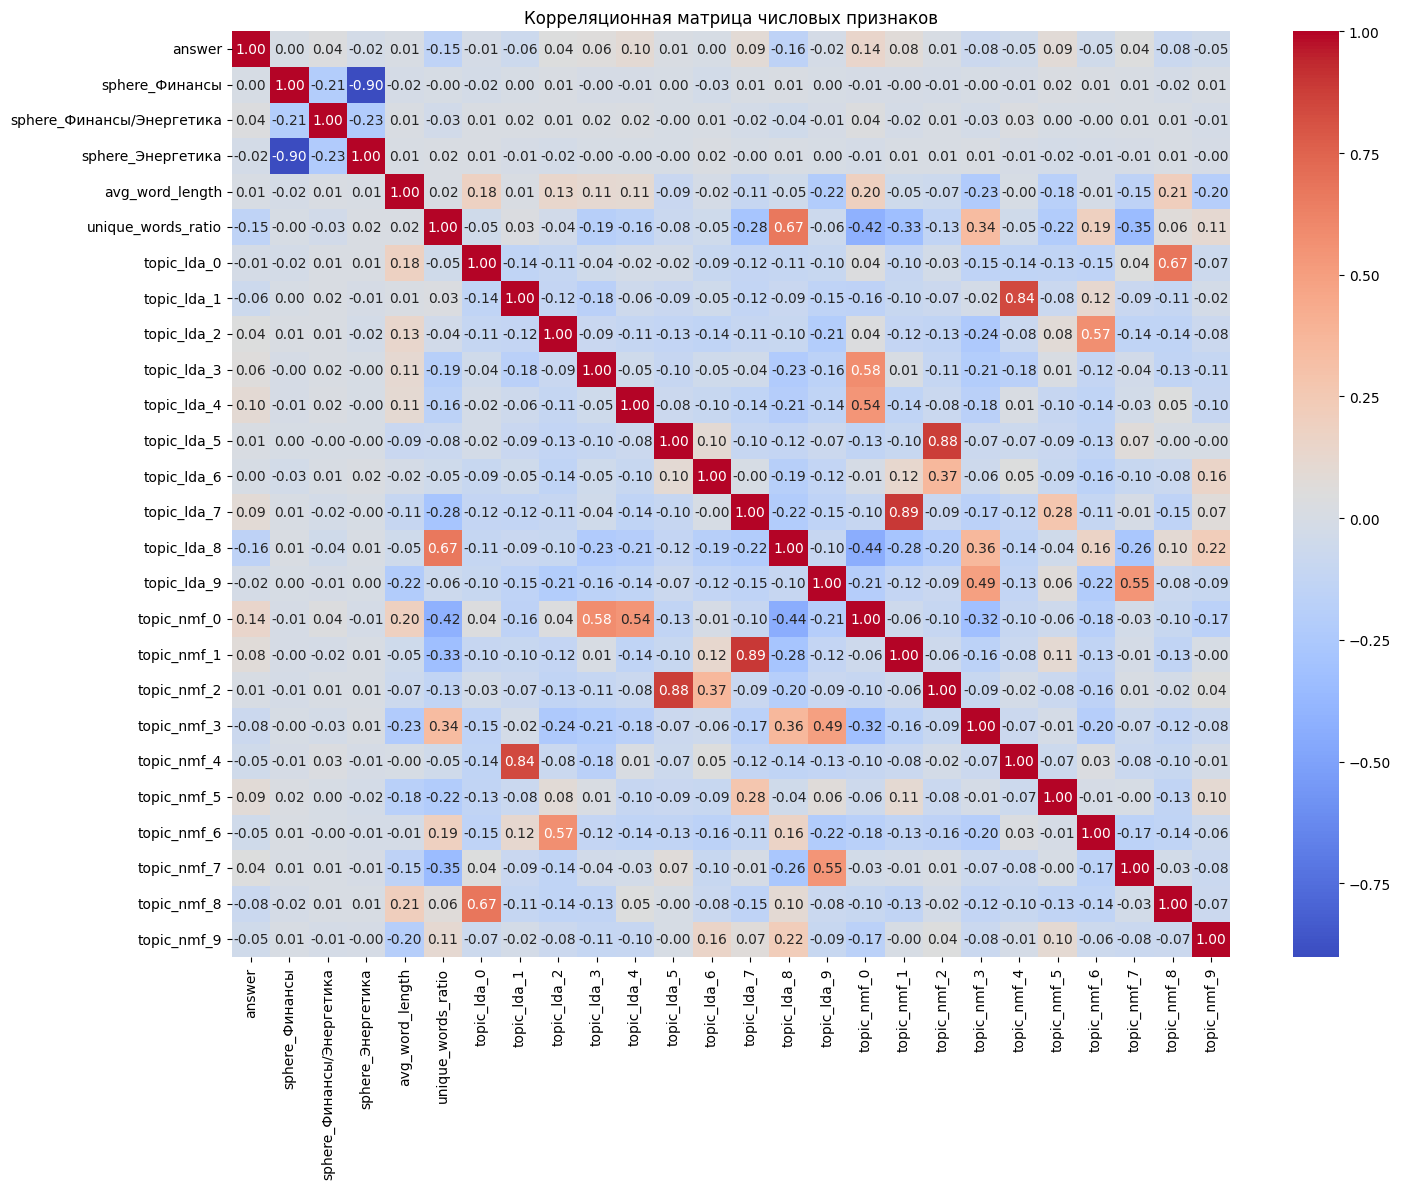

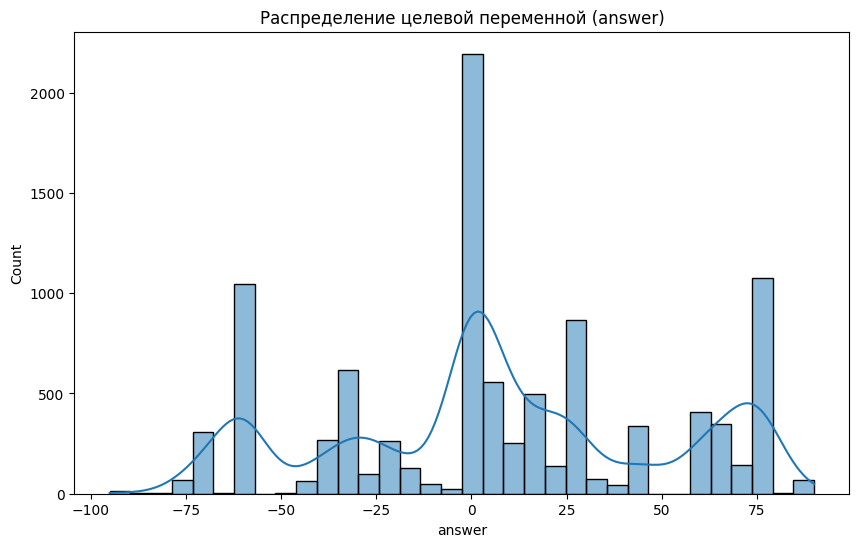

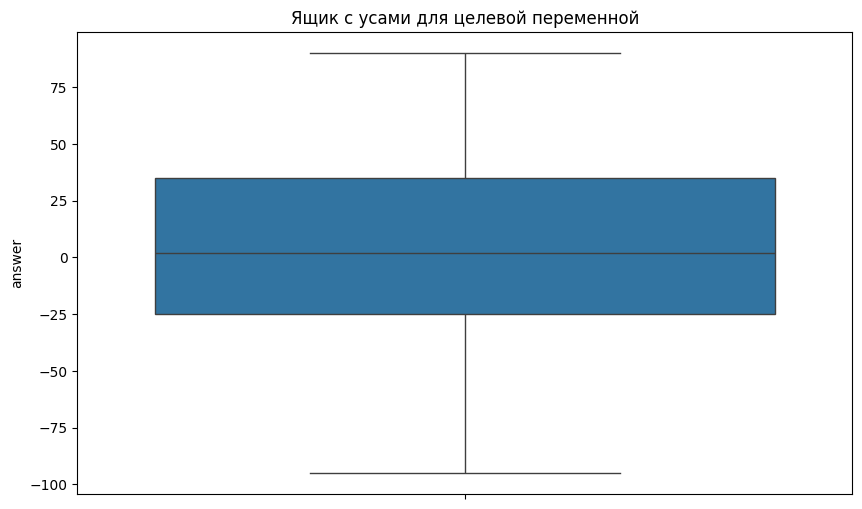

In [190]:
# Корреляционный анализ
numeric_cols = news_sentiment.select_dtypes(include=['int64', 'float64']).columns
correlation = news_sentiment[numeric_cols].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

# Анализ распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(news_sentiment['answer'], kde=True)
plt.title('Распределение целевой переменной (answer)')
plt.show()

# Проверка на выбросы
plt.figure(figsize=(10, 6))
sns.boxplot(y=news_sentiment['answer'])
plt.title('Ящик с усами для целевой переменной')
plt.show()


Эмбеддинги:

In [199]:

model_name = "sergeyzh/rubert-mini-frida"
model = SentenceTransformer(model_name)

def get_embeddings(texts, model):
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings

texts = news_sentiment['article_text'].tolist()
embeddings = get_embeddings(texts, model)

embeddings_df = pd.DataFrame(embeddings, columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])

news_sentiment = pd.concat([news_sentiment.drop(columns=['article_text']), embeddings_df], axis=1)

news_sentiment.dropna(inplace=True)

2025-03-17 20:57:21,906 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-03-17 20:57:21,907 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sergeyzh/rubert-mini-frida
2025-03-17 20:57:23,589 - sentence_transformers.SentenceTransformer - INFO - 25 prompts are loaded, with the keys: ['query', 'passage', 'CEDRClassification', 'GeoreviewClassification', 'GeoreviewClusteringP2P', 'HeadlineClassification', 'InappropriatenessClassification', 'KinopoiskClassification', 'MassiveIntentClassification', 'MassiveScenarioClassification', 'RuReviewsClassification', 'RUParaPhraserSTS', 'RuSTSBenchmarkSTS', 'STS22', 'RuSciBenchGRNTIClassification', 'RuSciBenchGRNTIClusteringP2P', 'RuSciBenchOECDClassification', 'RuSciBenchOECDClusteringP2P', 'SensitiveTopicsClassification', 'TERRa', 'Classification', 'MultilabelClassification', 'Clustering', 'PairClassification', 'STS']
2025-03-17 20:57:23,590 - sentence_transformers.Senten

KeyError: 'article_text'

In [198]:
news_sentiment

,answer,sphere_Финансы,sphere_Финансы/Энергетика,sphere_Энергетика,avg_word_length,unique_words_ratio,topic_lda_0,topic_lda_1,topic_lda_2,topic_lda_3,...,embedding_302,embedding_303,embedding_304,embedding_305,embedding_306,embedding_307,embedding_308,embedding_309,embedding_310,embedding_311
0,15.0,1.0,0.0,0.0,7.471429,0.735714,0.000840,0.000840,0.000840,0.000840,...,-0.010645,0.076837,0.026088,0.131530,0.047358,0.032372,-0.004263,-0.009119,-0.056180,0.052489
1,0.0,1.0,0.0,0.0,6.891892,0.718919,0.355194,0.001087,0.001087,0.140057,...,0.062028,0.090869,-0.010805,0.130877,0.048807,-0.064177,0.016843,0.014685,0.028362,0.022450
2,-75.0,1.0,0.0,0.0,7.108108,0.668919,0.093011,0.000827,0.090753,0.114474,...,0.062437,0.060767,-0.026828,0.024277,0.083942,-0.054157,-0.008058,-0.003733,-0.091136,0.098065
3,25.0,1.0,0.0,0.0,6.784884,0.732558,0.000720,0.000720,0.064765,0.000720,...,0.009958,0.047470,-0.018312,0.047560,0.063198,-0.011552,-0.007401,-0.026727,0.085805,0.037274
4,25.0,0.0,0.0,1.0,6.974359,0.769231,0.024534,0.001053,0.330446,0.554521,...,0.064995,-0.013059,0.023162,0.076077,-0.003167,-0.038641,-0.005784,0.002457,0.068927,0.080297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,5.0,0.0,1.0,0.0,7.937500,0.895833,0.003449,0.003449,0.003449,0.148480,...,-0.005063,0.026425,0.062003,0.070642,0.085324,0.009411,0.147568,-0.070811,-0.071817,0.067840
9953,0.0,0.0,0.0,1.0,8.200000,0.900000,0.003847,0.003847,0.087718,0.003847,...,-0.013494,-0.006824,-0.044526,0.113242,0.057523,-0.039237,0.027447,0.007510,0.013440,0.002699
9954,-60.0,1.0,0.0,0.0,7.903846,0.923077,0.081588,0.002632,0.384877,0.002633,...,0.092842,-0.047368,-0.040927,-0.014640,0.016762,-0.015553,0.094536,0.095049,0.042889,0.049096
9955,60.0,1.0,0.0,0.0,6.830508,0.830508,0.002500,0.002501,0.303869,0.002501,...,0.019683,-0.053139,0.003336,0.101668,0.056147,-0.004231,0.064831,-0.005532,0.066672,0.095128


In [194]:
news_sentiment['answer'] = news_sentiment['answer'].apply(float)

In [195]:
# mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mape = mean_absolute_percentage_error(y_test, y_pred)

# print(f'''
# MAE: {mae}
# RMSE: {rmse}
# R2: {r2}
# MAPE: {mape}
# ''')

In [196]:
news_sentiment.drop(columns=['date', 'source', 'tokens'], inplace=True)

In [197]:
news_sentiment

,answer,sphere_Финансы,sphere_Финансы/Энергетика,sphere_Энергетика,avg_word_length,unique_words_ratio,topic_lda_0,topic_lda_1,topic_lda_2,topic_lda_3,...,embedding_302,embedding_303,embedding_304,embedding_305,embedding_306,embedding_307,embedding_308,embedding_309,embedding_310,embedding_311
0,15.0,1.0,0.0,0.0,7.471429,0.735714,0.000840,0.000840,0.000840,0.000840,...,-0.010645,0.076837,0.026088,0.131530,0.047358,0.032372,-0.004263,-0.009119,-0.056180,0.052489
1,0.0,1.0,0.0,0.0,6.891892,0.718919,0.355194,0.001087,0.001087,0.140057,...,0.062028,0.090869,-0.010805,0.130877,0.048807,-0.064177,0.016843,0.014685,0.028362,0.022450
2,-75.0,1.0,0.0,0.0,7.108108,0.668919,0.093011,0.000827,0.090753,0.114474,...,0.062437,0.060767,-0.026828,0.024277,0.083942,-0.054157,-0.008058,-0.003733,-0.091136,0.098065
3,25.0,1.0,0.0,0.0,6.784884,0.732558,0.000720,0.000720,0.064765,0.000720,...,0.009958,0.047470,-0.018312,0.047560,0.063198,-0.011552,-0.007401,-0.026727,0.085805,0.037274
4,25.0,0.0,0.0,1.0,6.974359,0.769231,0.024534,0.001053,0.330446,0.554521,...,0.064995,-0.013059,0.023162,0.076077,-0.003167,-0.038641,-0.005784,0.002457,0.068927,0.080297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,5.0,0.0,1.0,0.0,7.937500,0.895833,0.003449,0.003449,0.003449,0.148480,...,-0.005063,0.026425,0.062003,0.070642,0.085324,0.009411,0.147568,-0.070811,-0.071817,0.067840
9953,0.0,0.0,0.0,1.0,8.200000,0.900000,0.003847,0.003847,0.087718,0.003847,...,-0.013494,-0.006824,-0.044526,0.113242,0.057523,-0.039237,0.027447,0.007510,0.013440,0.002699
9954,-60.0,1.0,0.0,0.0,7.903846,0.923077,0.081588,0.002632,0.384877,0.002633,...,0.092842,-0.047368,-0.040927,-0.014640,0.016762,-0.015553,0.094536,0.095049,0.042889,0.049096
9955,60.0,1.0,0.0,0.0,6.830508,0.830508,0.002500,0.002501,0.303869,0.002501,...,0.019683,-0.053139,0.003336,0.101668,0.056147,-0.004231,0.064831,-0.005532,0.066672,0.095128


2025-03-17 20:15:58,676 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-03-17 20:15:58,676 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
c:\Users\Ivan\PycharmProjects\CodeCats\.venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ivan\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer M

AttributeError: 'SentimentModel' object has no attribute 'train_all_models'

Гипотеза 2: классификация и метрика исходя из вероятности

Переведем таргет в кат формат

In [113]:
news_sentiment[news_sentiment['answer'] == 0]


,answer,sphere_Финансы,sphere_Финансы/Энергетика,sphere_Энергетика,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_302,embedding_303,embedding_304,embedding_305,embedding_306,embedding_307,embedding_308,embedding_309,embedding_310,embedding_311
1,0.0,1.0,0.0,0.0,0.049492,0.003223,0.022405,-0.022168,-0.033943,-0.036216,...,0.015524,0.053143,0.004405,0.004664,-0.020927,-0.036633,-0.048173,0.073890,0.000414,-0.037973
7,0.0,1.0,0.0,0.0,-0.000273,0.030394,0.035661,-0.064451,-0.016236,-0.016484,...,0.028709,-0.071106,-0.041188,0.088101,0.024585,-0.015575,0.014109,-0.027733,0.025211,-0.085193
18,0.0,0.0,0.0,1.0,0.008718,0.043706,0.073774,-0.055849,-0.031516,-0.024239,...,0.001967,-0.062040,0.000632,0.050425,0.088416,0.007068,-0.023280,-0.040830,0.055683,-0.031369
27,0.0,0.0,1.0,0.0,0.062391,0.003693,0.017390,-0.070047,-0.038072,-0.047709,...,0.044188,-0.056655,-0.093838,0.116657,0.028908,0.007643,0.017555,0.020915,0.004395,-0.088141
29,0.0,0.0,0.0,1.0,0.034799,-0.015171,0.017816,-0.067834,0.009117,-0.064093,...,0.026150,0.008485,-0.042283,0.064340,-0.024567,-0.015351,-0.026852,0.074954,0.003463,-0.064617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,0.0,1.0,0.0,0.0,0.001216,-0.004305,0.041798,-0.073543,-0.004696,-0.010228,...,-0.029822,-0.073458,0.027264,0.114905,0.014161,-0.033161,0.030948,0.051557,-0.057390,-0.064628
9923,0.0,1.0,0.0,0.0,0.043851,-0.000852,-0.007596,-0.042431,0.009327,-0.003502,...,0.021477,-0.040690,0.011663,-0.032388,0.004581,0.013552,-0.028921,0.047707,0.000326,-0.088735
9935,0.0,0.0,0.0,1.0,0.024536,0.016083,-0.055159,-0.061768,-0.015249,-0.018125,...,0.039145,-0.069981,0.051740,0.020252,-0.039497,0.047352,0.027716,0.075201,-0.034487,-0.131873
9944,0.0,0.0,0.0,1.0,0.034882,-0.006933,0.034749,-0.058505,-0.003204,-0.054234,...,-0.020424,-0.066967,0.031528,0.004671,0.043294,0.023100,0.010519,0.051364,0.023725,-0.072441


In [114]:
news_sentiment['answer'] = news_sentiment['answer'] >= 0
news_sentiment['answer'] = news_sentiment['answer'].apply(int)

In [115]:
news_sentiment.drop(columns=['date', 'source'])

KeyError: "['date', 'source'] not found in axis"


--- Training model for sphere_Финансы ---
Model saved to models\sphere_Финансы_model.txt
[ 33.29192066  36.61492911  28.21912375 ... -46.9162264   11.24401088
  -9.09490809] 8723    30.0
8564    75.0
125     60.0
5567   -20.0
809    -60.0
        ... 
4518     2.0
4064   -30.0
3605   -70.0
2398     5.0
3953   -30.0
Name: answer, Length: 1010, dtype: float64
Metrics for sphere_Финансы:
MSE: 1356.9915
RMSE: 36.8374
MAE: 28.9530
R^2: 0.2800
Custom direction metric: 0.7733
Feature importance saved to models\sphere_Финансы_feature_importance.csv


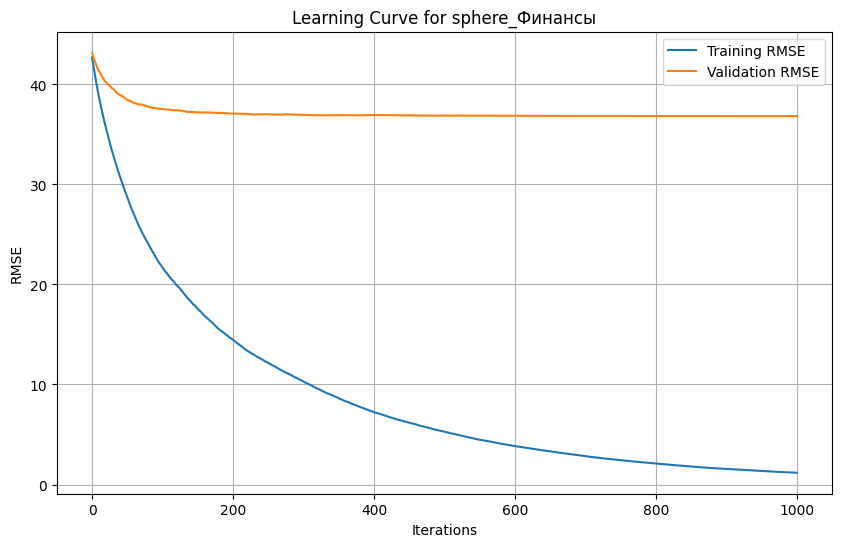

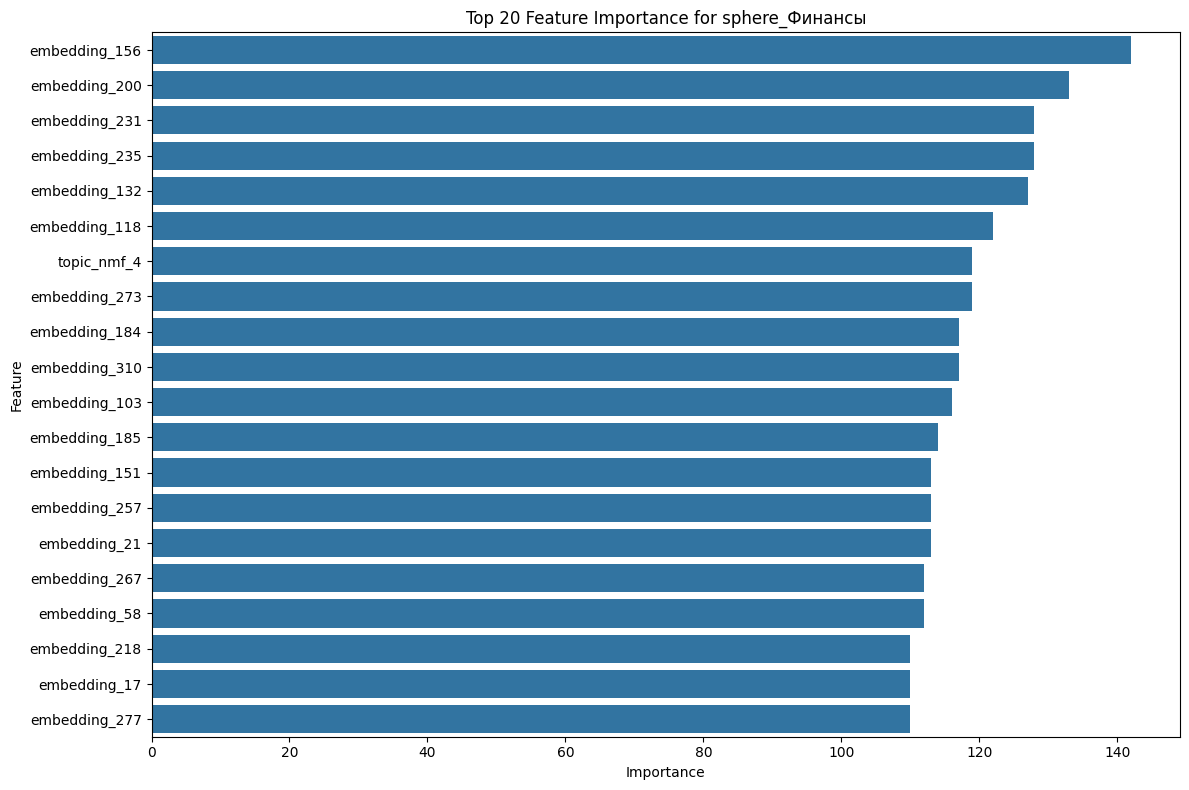


--- Training model for sphere_Энергетика ---
Model saved to models\sphere_Энергетика_model.txt
[-44.7065467  -14.24978745  -7.33512345 ...   4.5212022   14.75300351
  -8.23977952] 6654   -60.0
4985     2.0
6424     0.0
8212     0.0
3115     5.0
        ... 
6382     0.0
1390   -60.0
3882    70.0
8874   -90.0
646    -70.0
Name: answer, Length: 1085, dtype: float64
Metrics for sphere_Энергетика:
MSE: 1287.6465
RMSE: 35.8838
MAE: 28.2887
R^2: 0.3124
Custom direction metric: 0.8055
Feature importance saved to models\sphere_Энергетика_feature_importance.csv


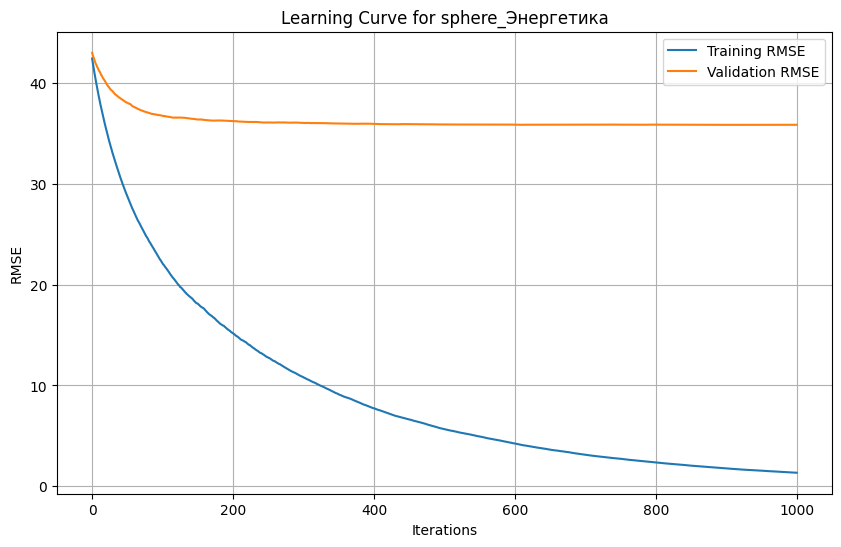

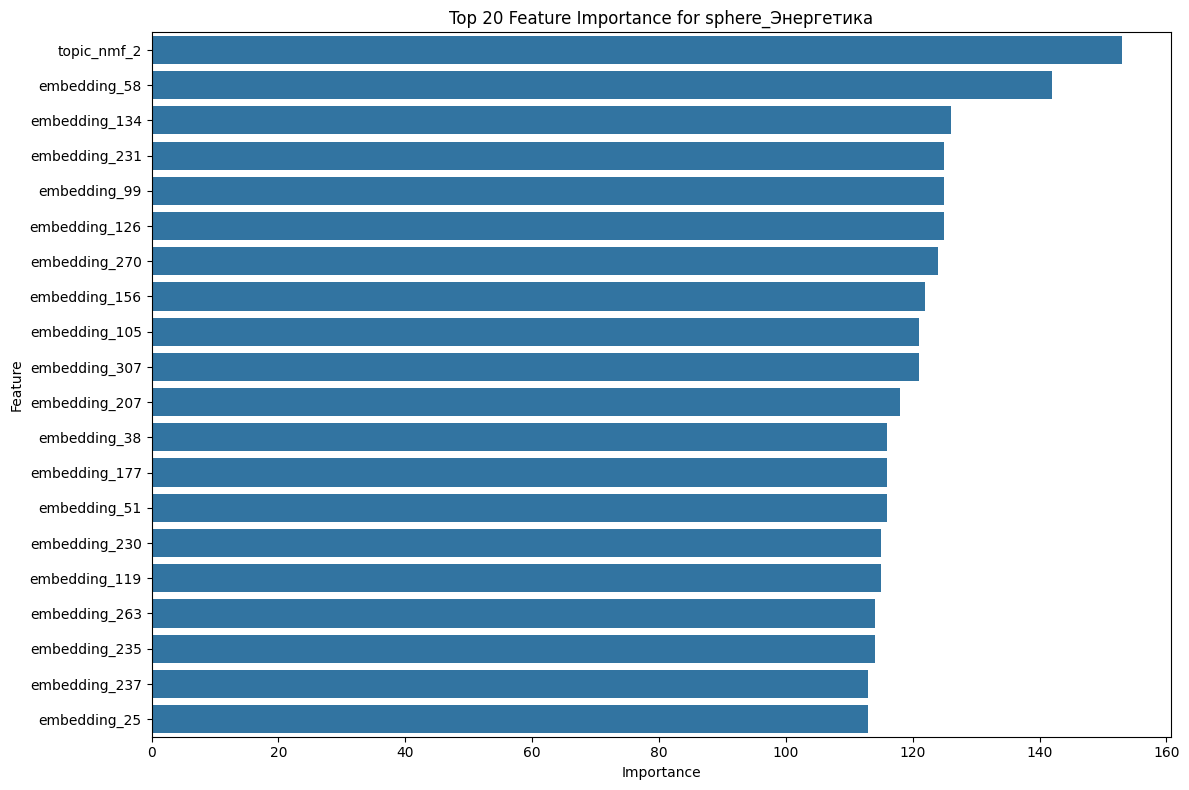


--- Overall Summary ---

sphere_Финансы:
MSE: 1356.9915
RMSE: 36.8374
MAE: 28.9530
R^2: 0.2800

Top 5 Important Features:
           Feature  Importance
179  embedding_156         142
223  embedding_200         133
254  embedding_231         128
258  embedding_235         128
155  embedding_132         127

sphere_Энергетика:
MSE: 1287.6465
RMSE: 35.8838
MAE: 28.2887
R^2: 0.3124

Top 5 Important Features:
           Feature  Importance
15     topic_nmf_2         153
81    embedding_58         142
157  embedding_134         126
254  embedding_231         125
122   embedding_99         125


In [220]:
spheres = ['sphere_Финансы', 'sphere_Энергетика']
models = {}
feature_importance_dfs = {}
metrics = {}

import os
if not os.path.exists('models'):
    os.makedirs('models')

for sphere in spheres:
    print(f"\n--- Training model for {sphere} ---")
    
    sphere_data = pd.concat([news_sentiment[news_sentiment[sphere] == 1].copy(), news_sentiment[news_sentiment['sphere_Финансы/Энергетика'] == 1].copy()])
    
    if len(sphere_data) == 0:
        print(f"No data for {sphere}, skipping...")
        continue
    
    X = sphere_data.drop(['answer'] + spheres, axis=1)
    y = sphere_data['answer']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LGBMRegressor(
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=7,
        random_state=42
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse',
    )
    
    models[sphere] = model
    
    model_filename = os.path.join('models', f"{sphere.replace('/', '_')}_model.txt")
    model.booster_.save_model(model_filename)
    print(f"Model saved to {model_filename}")
    
    y_pred = model.predict(X_test)
    print(y_pred, y_test)
    metrics[sphere] = {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'Custom direction metric': sum([int(y_test.tolist()[i] * y_pred.tolist()[i] >= 0) for i in range(len(y_test))]) / len(y_test)
    }
    
    print(f"Metrics for {sphere}:")
    print(f"MSE: {metrics[sphere]['mse']:.4f}")
    print(f"RMSE: {metrics[sphere]['rmse']:.4f}")
    print(f"MAE: {metrics[sphere]['mae']:.4f}")
    print(f"R^2: {metrics[sphere]['r2']:.4f}")
    print(f"Custom direction metric: {metrics[sphere]['Custom direction metric']:.4f}")
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    feature_importance_dfs[sphere] = feature_importance
    
    feature_importance_filename = os.path.join('models', f"{sphere.replace('/', '_')}_feature_importance.csv")
    feature_importance.to_csv(feature_importance_filename, index=False)
    print(f"Feature importance saved to {feature_importance_filename}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(model.evals_result_['training']['rmse'], label='Training RMSE')
    plt.plot(model.evals_result_['valid_1']['rmse'], label='Validation RMSE')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve for {sphere}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top 20 Feature Importance for {sphere}')
    plt.tight_layout()
    plt.show()
print("\n--- Overall Summary ---")
for sphere in spheres:
    if sphere in metrics:
        print(f"\n{sphere}:")
        print(f"MSE: {metrics[sphere]['mse']:.4f}")
        print(f"RMSE: {metrics[sphere]['rmse']:.4f}")
        print(f"MAE: {metrics[sphere]['mae']:.4f}")
        print(f"R^2: {metrics[sphere]['r2']:.4f}")
        print("\nTop 5 Important Features:")
        print(feature_importance_dfs[sphere].head(5))

In [ ]:
def text_prep(text):
    pass

def predict(text, model_name):
    pass